## Lade Pakete

In [1]:
import os # um Pfad anzulegen oder zu ändern
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import lightgbm as lgb

#sklearn Pakete
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingRandomSearchCV, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PolynomialFeatures, LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, average_precision_score, recall_score, precision_score, precision_recall_curve, f1_score, classification_report, roc_auc_score, roc_curve
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif, mutual_info_regression
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer # ersetzen von fehlenden Werten
from sklearn.compose import ColumnTransformer
from scipy.stats import ttest_ind
from lightgbm import LGBMClassifier
from scipy.stats import randint, uniform, chi2_contingency
from sklearn.utils.class_weight import compute_class_weight

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostClassifier

from imblearn.over_sampling import SMOTE, BorderlineSMOTE # Oversampling
from imblearn.under_sampling import RandomUnderSampler # Undersampling
from imblearn.pipeline import Pipeline # spezielle Pipeline für SMOTE nötig

import xgboost as xgb
from xgboost import plot_importance

# tensorflow
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# statsmodel Pakete
import statsmodels.api as sm
import statsmodels.formula.api as smf

C:\Users\MLA6FE\.conda\envs\graduate\lib\site-packages\tqdm_joblib\__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Pfadeingabe

In [2]:
# Pfad zum lokalen Speicherort der Daten, r davor einfügen damit spezielle Zeichen auch als String erkannt werden
data_dir = r"C:\Users\MLA6FE\Desktop\Data_Science_Project\data"
file_path = os.path.join(data_dir, "bankaccounts.csv")

## CSV-Daten in data frame laden

In [3]:
df_bankaccounts = pd.read_csv(file_path)

## Überblick über Daten verschaffen

In [4]:
#df_bankaccounts.head() # erste 5 Zeilen des Datensatzes
#df.shape               # Anzahl der Zeilen und Spalten
#df.columns             # Spaltennamen
df_bankaccounts.info()  # Spaltennamen, 0-Werte, Datentypen

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 34 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

In [5]:
# Datensatz auf Duplikate überprüfen

#df_bankaccounts[df_bankaccounts.duplicated()] # zeigt ganze Zeilen mit den Duplikaten an
df_bankaccounts.duplicated().sum() # gibt Summe der doppelten Zeilen an

0

## Nicht benötigte Spalten löschen und unter X (unabhängige Variablen) und y (abhängige Variable) speichern

In [6]:
X = df_bankaccounts.drop(axis = 1, columns = ["x1", "x2", "fraud_bool"]) # löscht die gewünschten Spalten aus data frame
y = df_bankaccounts["fraud_bool"] # erzeugt data frame y mit gewünschter Spalte
X.shape, y.shape # gibt die Form der data frames aus

((1000000, 31), (1000000,))

## Häufigkeit der Werte der Zielgröße über alle Features

Prozentuale Verteilung: fraud_bool
0    98.897
1     1.103
Name: proportion, dtype: float64


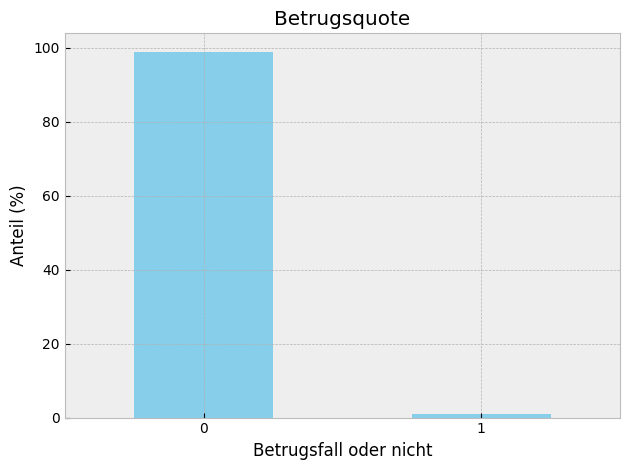

In [7]:
# Definiere style für alle folgenden plots
plt.style.use('bmh')

fraud_or_not = y.value_counts(normalize=True).sort_index() * 100 # zählt alle Häufigkeiten je Kategortie und sortiert es nach aufsteigendem index
# normalisiert die Werte und multipliziert sie mit 100 für eine prozentuale Darstellung

# gibt Tabelle aus mit prozentualer Verteilung
print("Prozentuale Verteilung:", fraud_or_not)

#erstellt barplot
fraud_or_not.plot(kind="bar", color="skyblue")
plt.ylabel("Anteil (%)")
plt.xlabel("Betrugsfall oder nicht")
plt.title("Betrugsquote")
plt.xticks(rotation=0) # damit Zahlen nicht gedreht werden

plt.tight_layout()  # saubere Darstellung
plt.show()

## Verteilung der geschützten Attribute in Barplots

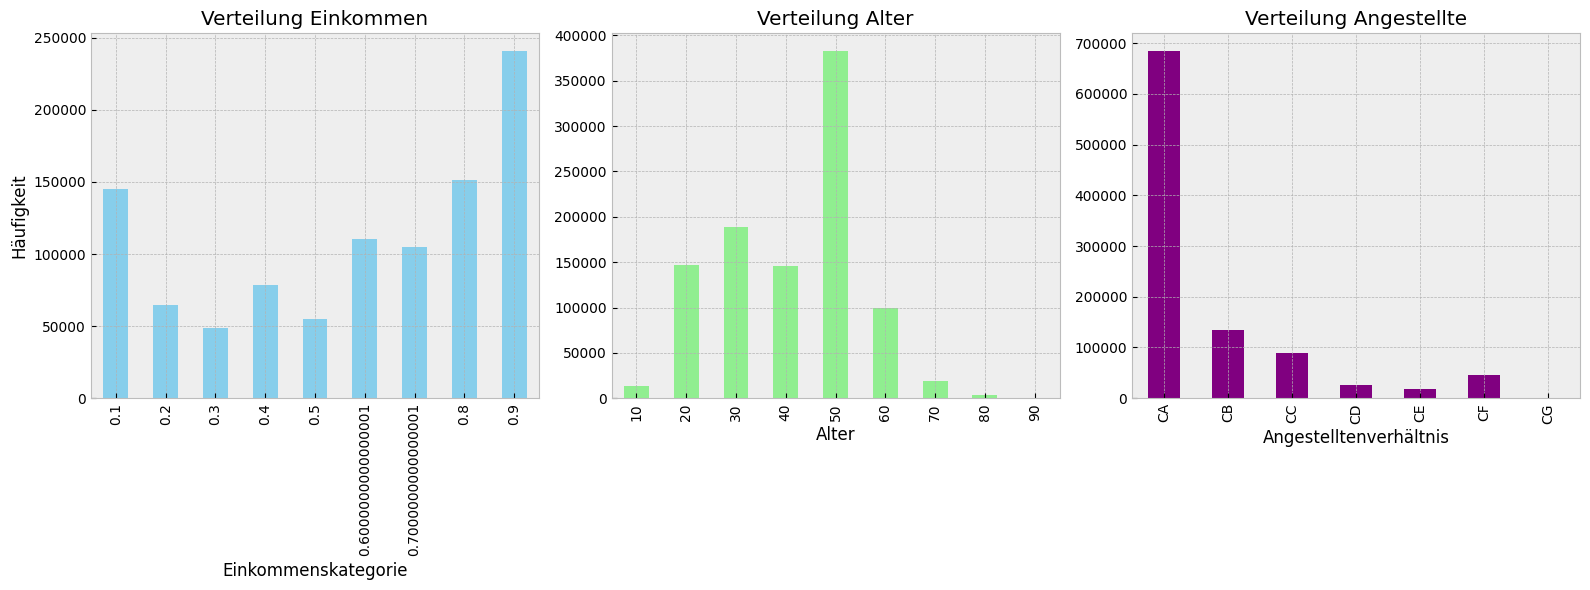

In [8]:
# Suplots anlegen
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

# income
X["income"].value_counts().sort_index().plot(kind="bar", color="skyblue", ax=axes[0]) # zählt alle Häufigkeiten je Kategortie und sortiert es nach aufsteigendem index
axes[0].set_title("Verteilung Einkommen")
axes[0].set_xlabel("Einkommenskategorie")
axes[0].set_ylabel("Häufigkeit")

#costumer age
X["customer_age"].value_counts().sort_index().plot(kind="bar", color="lightgreen", ax=axes[1])
axes[1].set_title("Verteilung Alter")
axes[1].set_xlabel("Alter")

#employment status
X["employment_status"].value_counts().sort_index().plot(kind="bar", color="purple", ax=axes[2])
axes[2].set_title("Verteilung Angestellte")
axes[2].set_xlabel("Angestelltenverhältnis")

plt.tight_layout()  # saubere Darstellung
plt.show()

## Häufigkeit der Zielgröße bei den geschützten Attributen

fraud_bool          0         1
income                         
0.1         99.404368  0.595632
0.2         99.291905  0.708095
0.3         99.251819  0.748181
0.4         99.234791  0.765209
0.5         99.244694  0.755306
0.6         99.221076  0.778924
0.7         99.074118  0.925882
0.8         98.954552  1.045448
0.9         97.962765  2.037235
fraud_bool            0         1
customer_age                     
10            99.584488  0.415512
20            99.358987  0.641013
30            98.913660  1.086340
40            98.403872  1.596128
50            99.041917  0.958083
60            98.478383  1.521617
70            98.047084  1.952916
80            97.493606  2.506394
90            97.058824  2.941176
fraud_bool                 0         1
employment_status                     
CA                 98.717337  1.282663
CB                 99.343610  0.656390
CC                 98.717013  1.282987
CD                 99.635995  0.364005
CE                 99.743576  0.256424
C

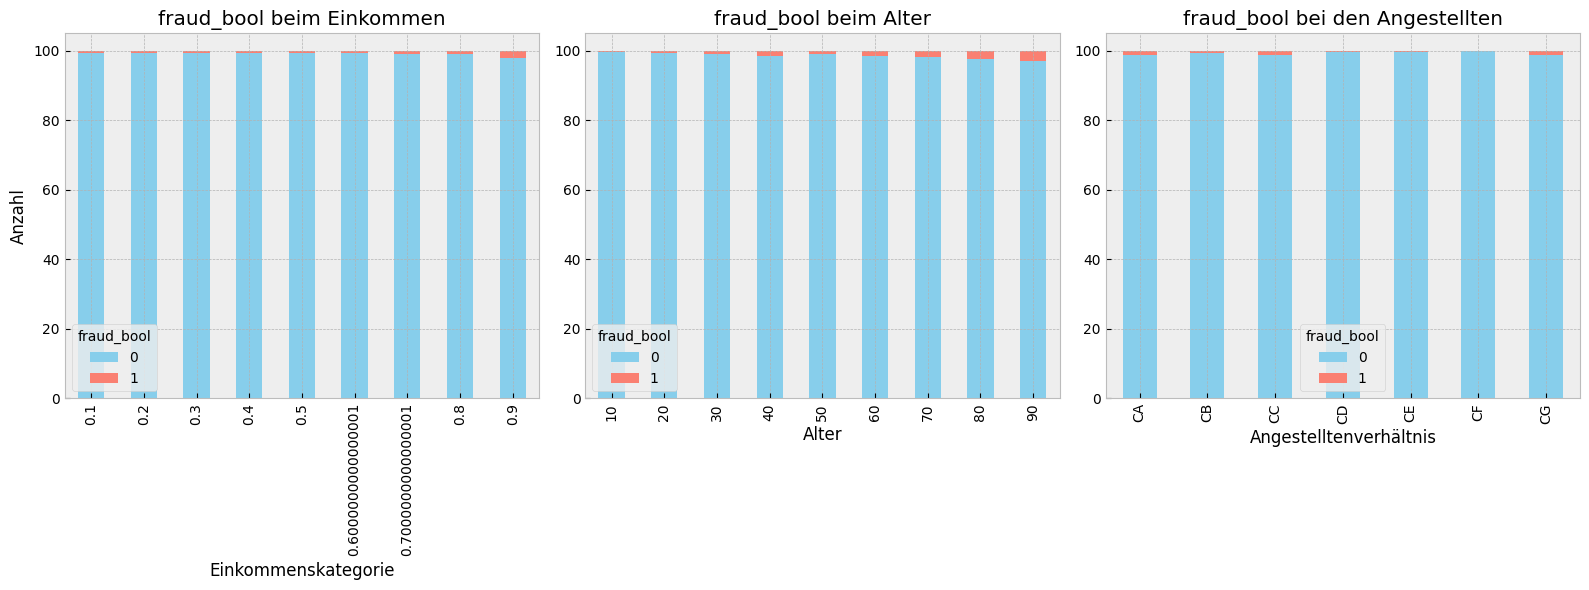

In [9]:
# erstelle crosstabs, Kreuztabellen wie oft jede Kombination mit 0, 1 vorkommt
crosstab_income = pd.crosstab(X["income"], y, normalize='index') * 100
crosstab_costumer_age = pd.crosstab(X["customer_age"], y, normalize='index') * 100
crosstab_employment_status = pd.crosstab(X["employment_status"], y, normalize='index') * 100

# Tabelle mit den Prozentwerten ausgeben
print(crosstab_income)
print(crosstab_costumer_age)
print(crosstab_employment_status)

# Suplots anlegen
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

# income
crosstab_income.plot(kind='bar', stacked=True, color=['skyblue', 'salmon'], ax=axes[0])
axes[0].set_title("fraud_bool beim Einkommen")
axes[0].set_xlabel("Einkommenskategorie")
axes[0].set_ylabel("Anzahl")

#costumer age
crosstab_costumer_age.plot(kind='bar', stacked=True, color=['skyblue', 'salmon'], ax=axes[1])
axes[1].set_title("fraud_bool beim Alter")
axes[1].set_xlabel("Alter")

#employment status
crosstab_employment_status.plot(kind='bar', stacked=True, color=['skyblue', 'salmon'], ax=axes[2])
axes[2].set_title("fraud_bool bei den Angestellten")
axes[2].set_xlabel("Angestelltenverhältnis")

plt.tight_layout()  # saubere Darstellung
plt.show()

## Verteilung der Werte aller Features

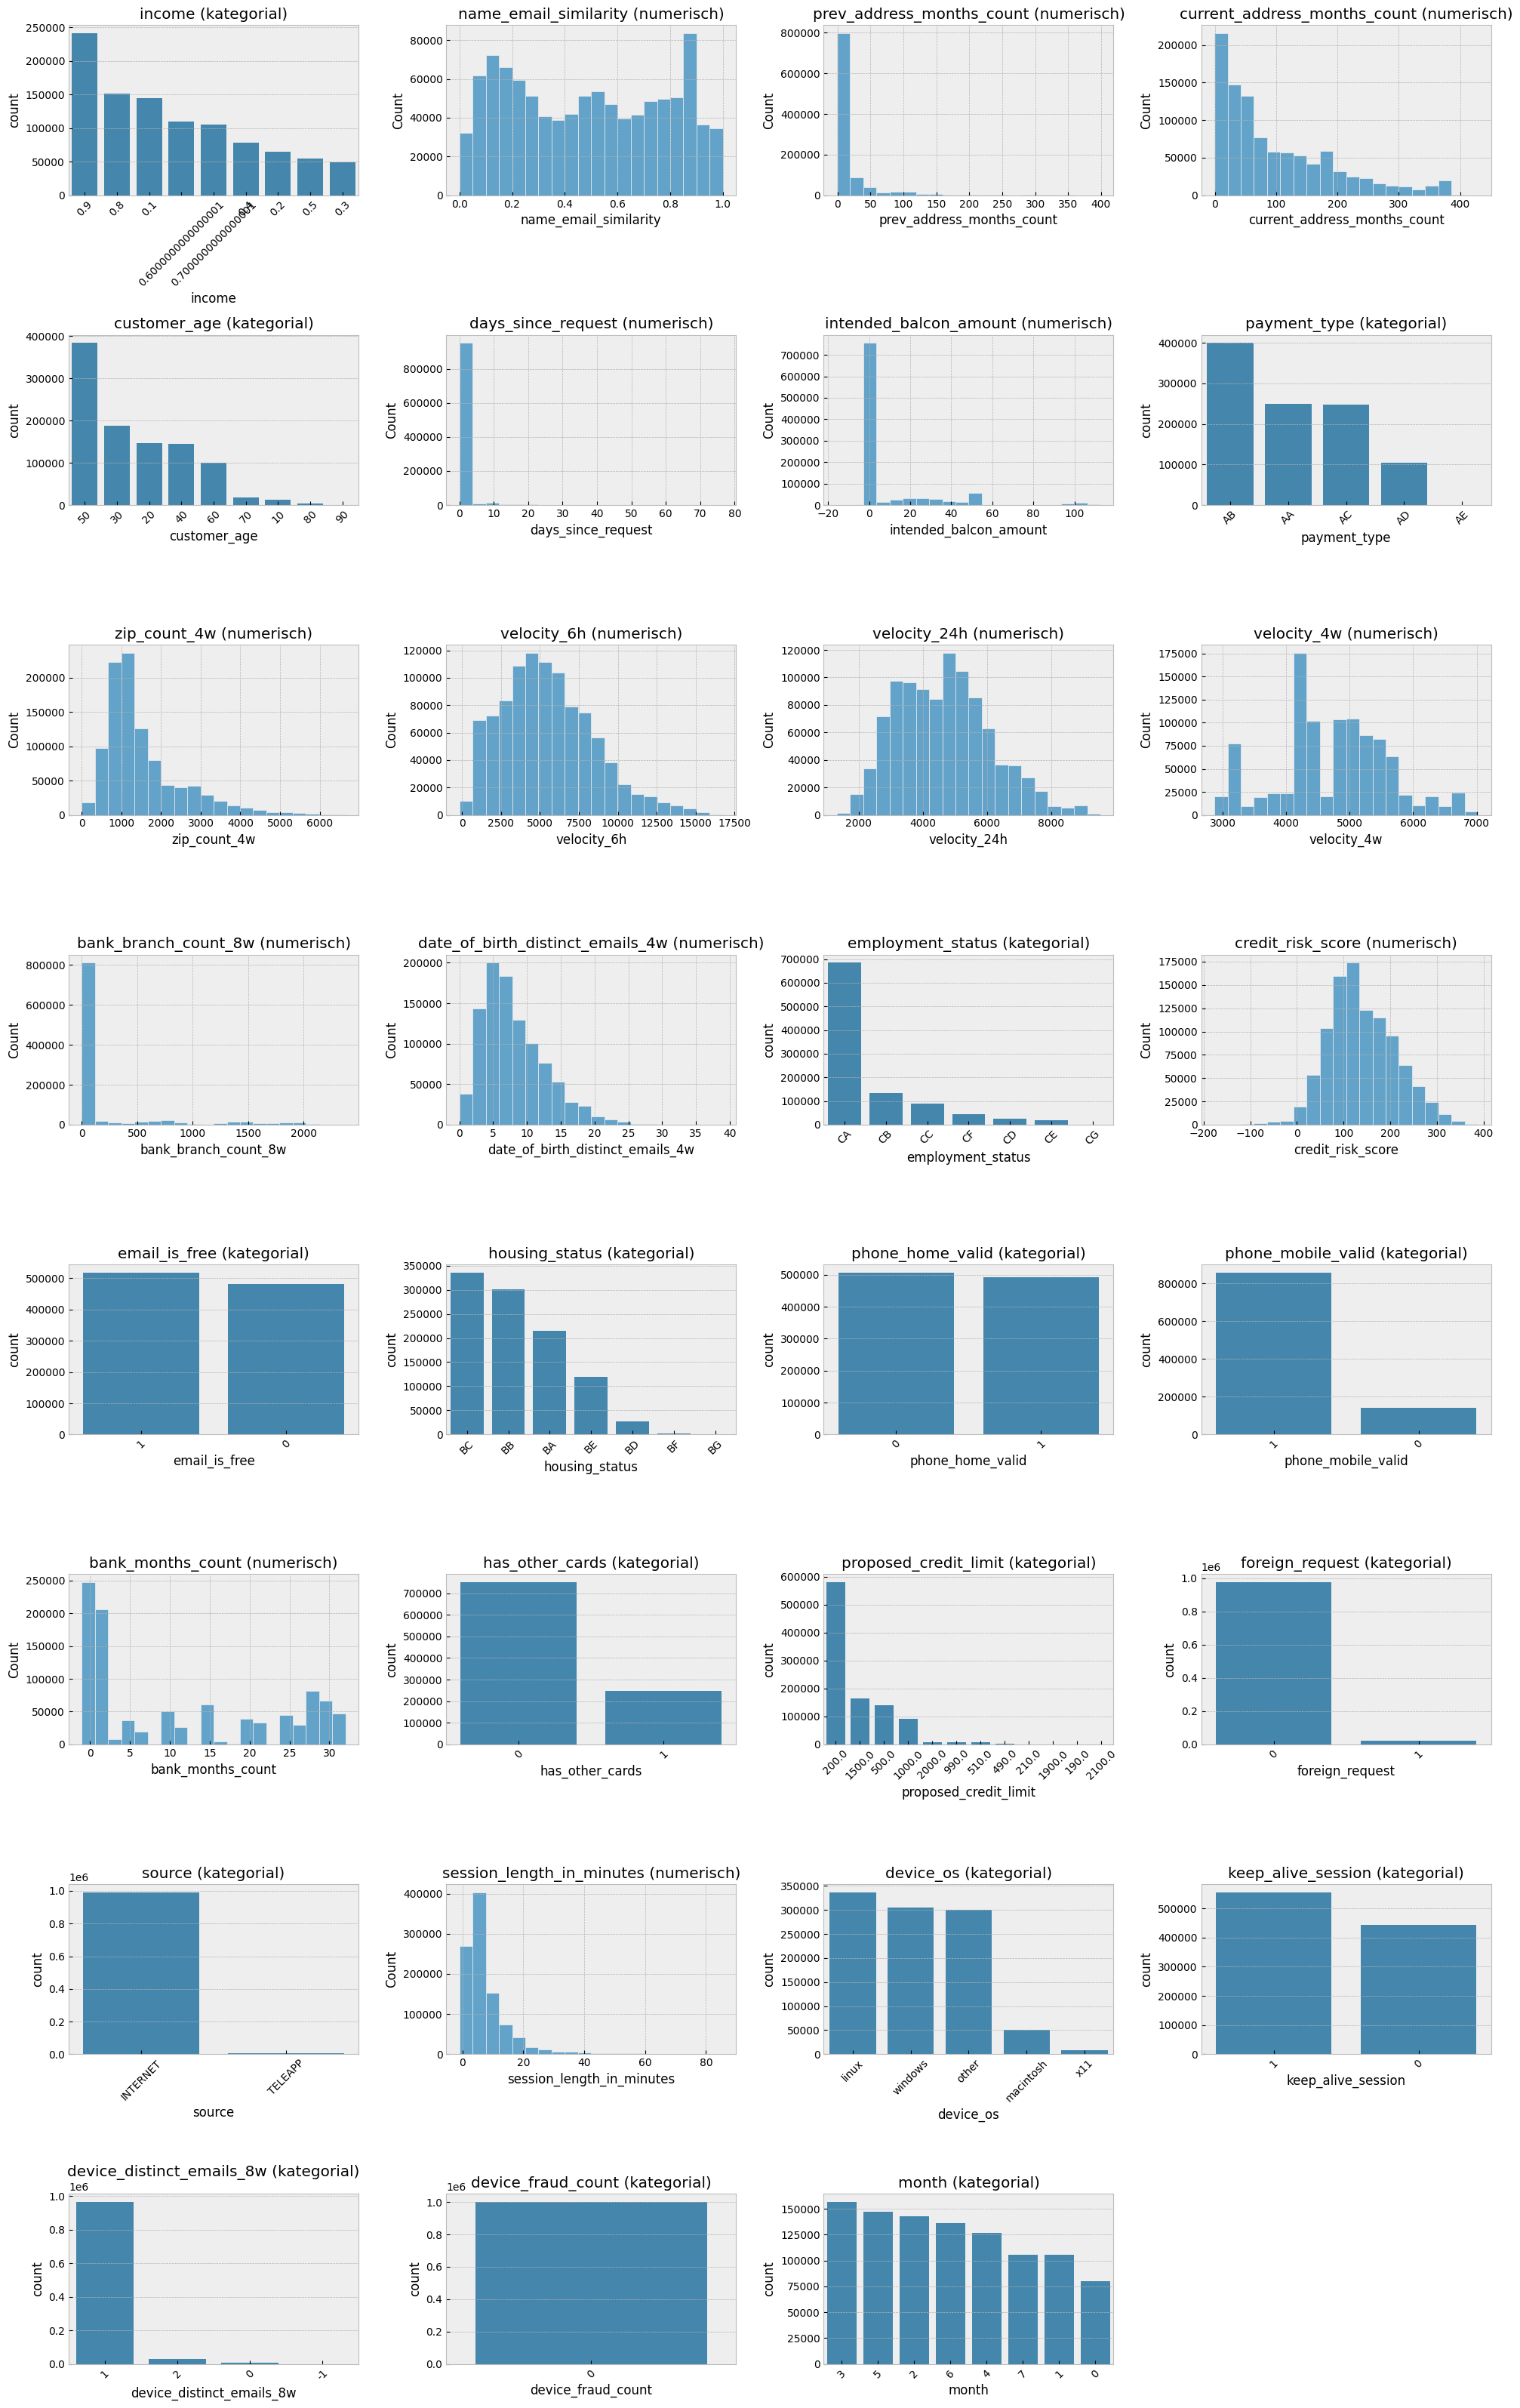

In [10]:
# Darstellen aller Daten
# Anzahl der Spalten
cols = X.columns
n_cols = 4  # Spalten pro Reihe
n_rows = math.ceil(len(cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
axes = axes.flatten()  # 2D-Array in 1D für einfaches Iterieren

for i, col in enumerate(cols):
    ax = axes[i]
    
    # Kategoriale Features
    if X[col].dtype == 'object' or X[col].nunique() < 20:
        sns.countplot(x=col, data=X, order=X[col].value_counts().index, ax=ax)
        ax.set_title(f'{col} (kategorial)')
        ax.tick_params(axis="x", rotation=45)

    # Numerische Features
    else:
        sns.histplot(X[col], bins=20, kde=False, ax=ax)
        ax.set_title(f'{col} (numerisch)')

# Leere Achsen ausblenden
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Density Plot der numerischen Feature

C:\Users\MLA6FE\AppData\Local\Temp\ipykernel_9200\298340934.py:20: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df_bankaccounts[df_bankaccounts['fraud_bool'] == 0][feature], fill=True, ax=ax, label='Not Fraud')
C:\Users\MLA6FE\AppData\Local\Temp\ipykernel_9200\298340934.py:22: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df_bankaccounts[df_bankaccounts['fraud_bool'] == 1][feature], fill=True, ax=ax, label='Fraud')
C:\Users\MLA6FE\AppData\Local\Temp\ipykernel_9200\298340934.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


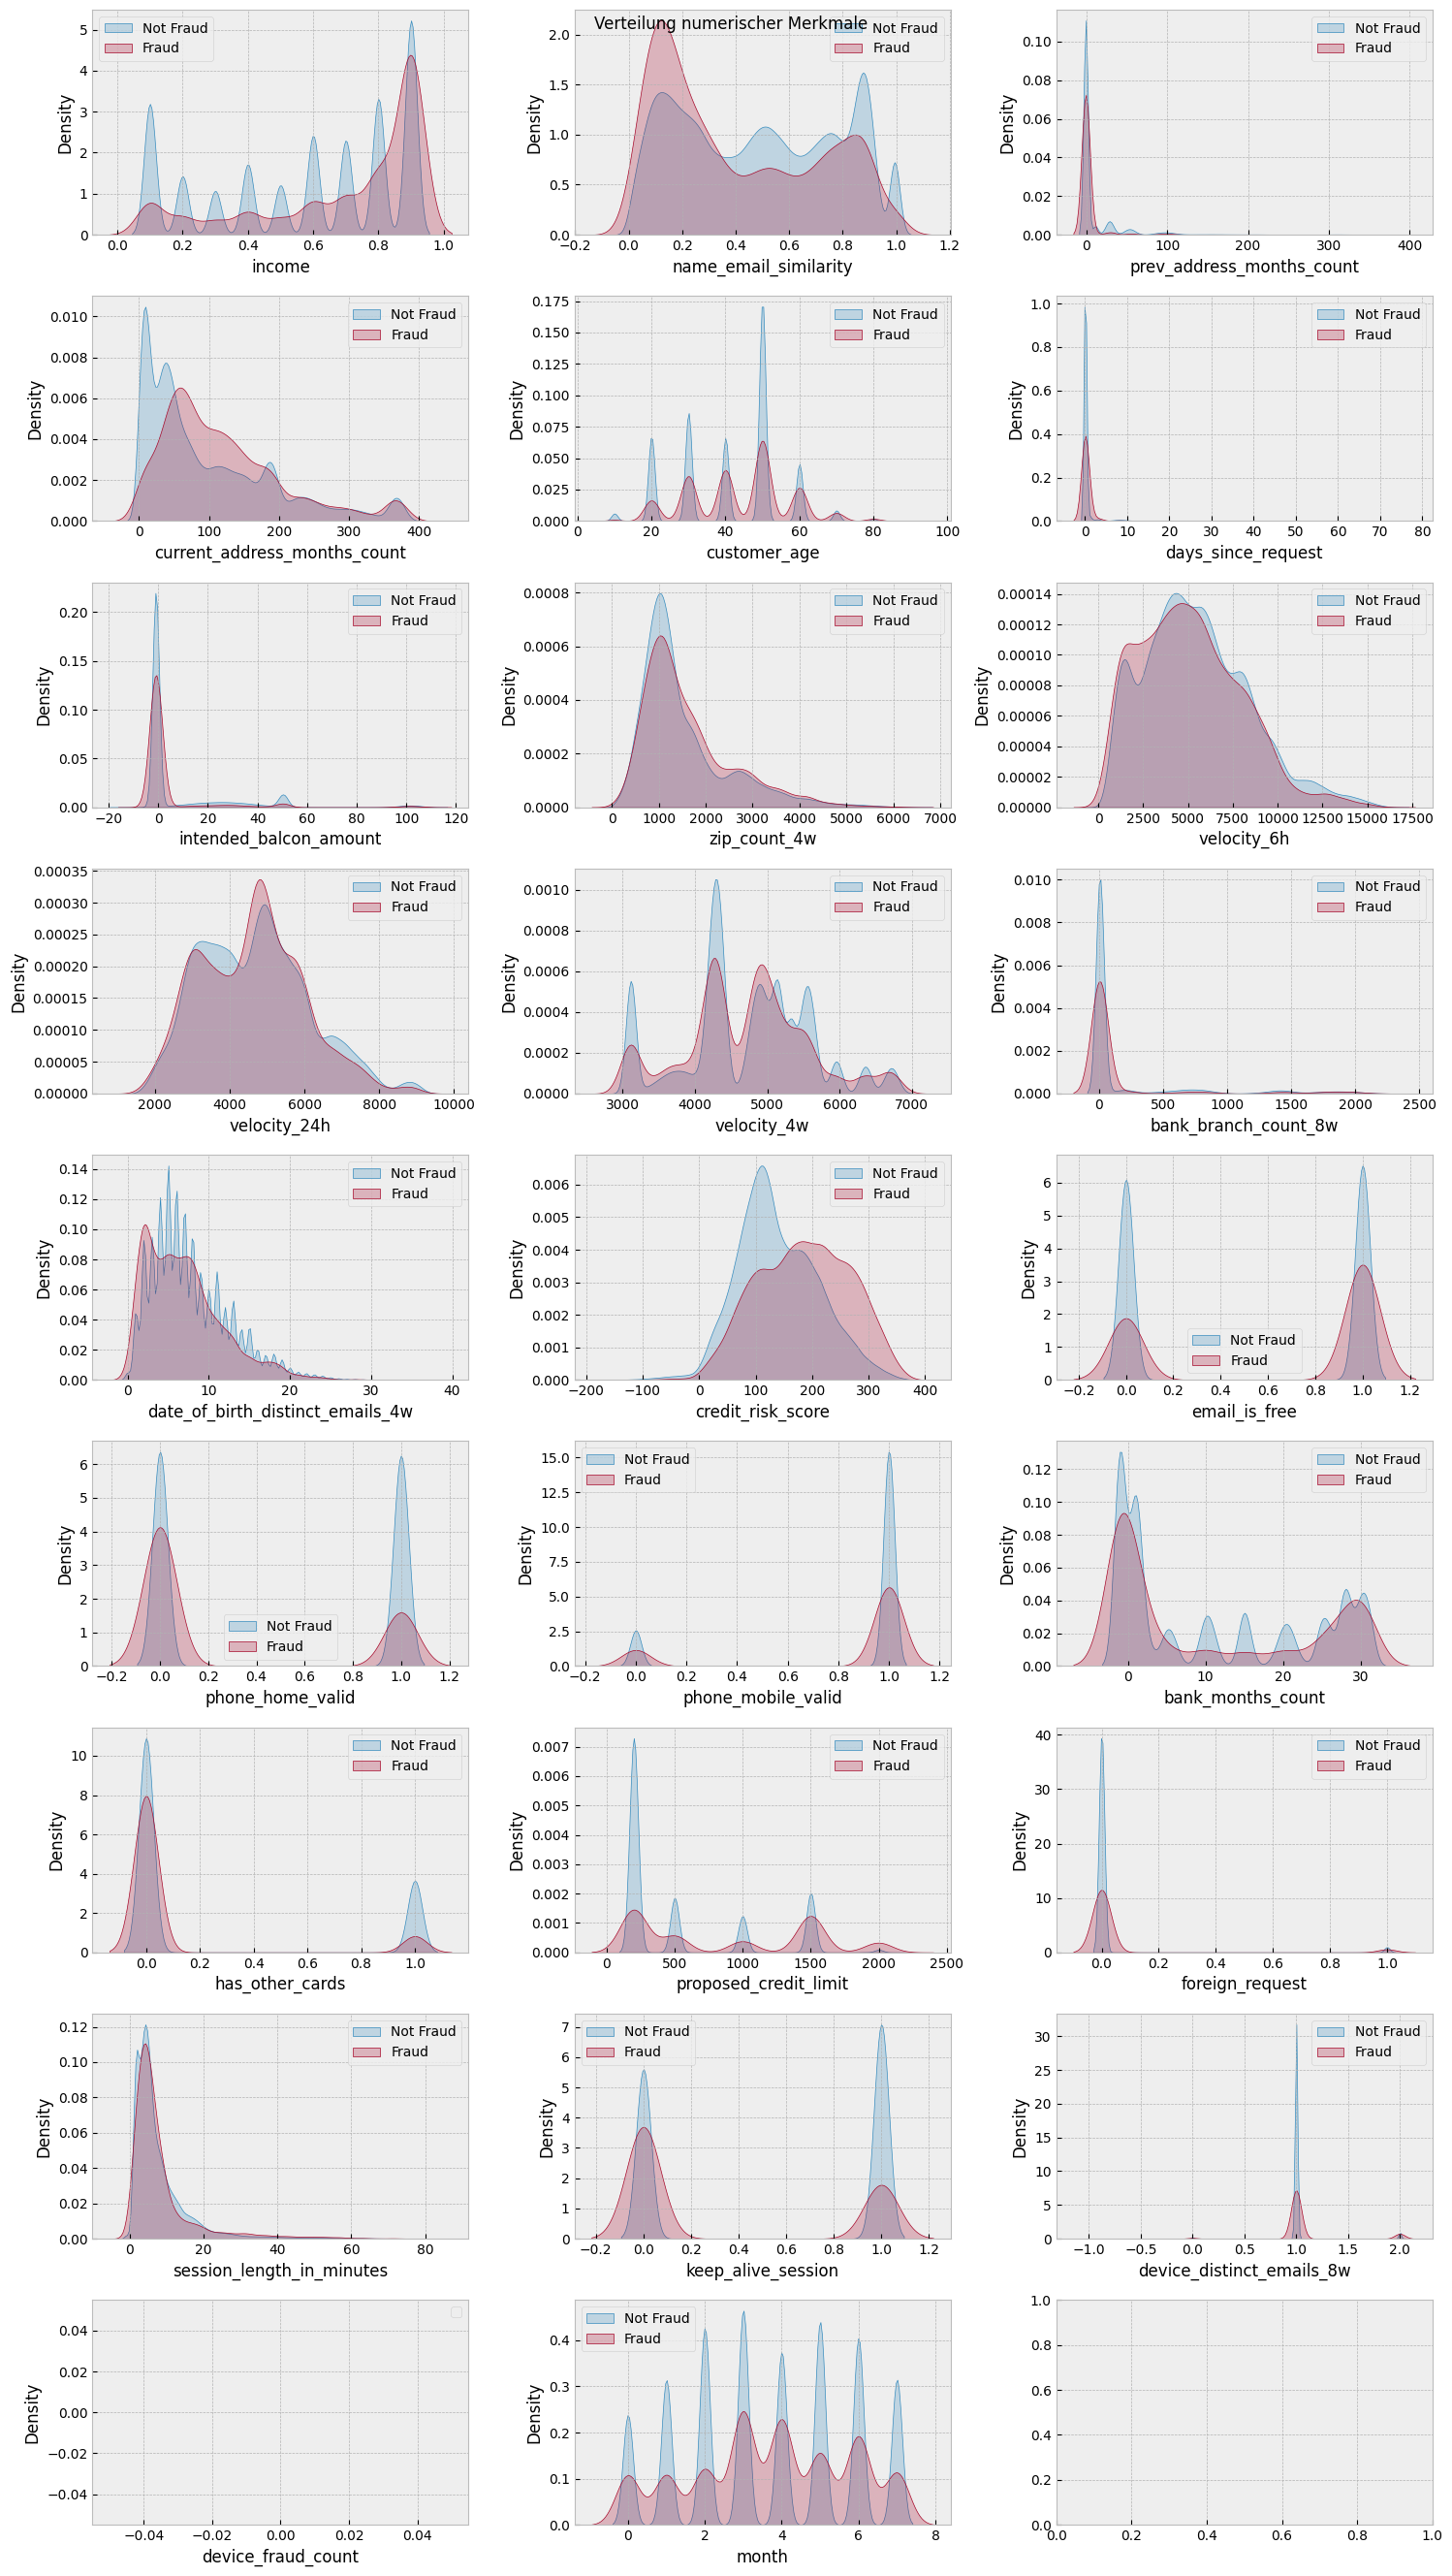

In [11]:
# Einzelplots numerischer Daten

# Alle numerischen Spalten auswählen
numeric_features = X.select_dtypes(include=['int', 'float']).columns
    
n_cols = 3

n_rows = int(np.ceil(len(numeric_features) / n_cols))

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, n_rows * 3))
 
# Titel

fig.suptitle('Verteilung numerischer Merkmale')
 
for i, feature in enumerate(numeric_features):

    ax = axes[i // 3][i % 3]

    sns.kdeplot(data=df_bankaccounts[df_bankaccounts['fraud_bool'] == 0][feature], fill=True, ax=ax, label='Not Fraud')

    sns.kdeplot(data=df_bankaccounts[df_bankaccounts['fraud_bool'] == 1][feature], fill=True, ax=ax, label='Fraud')

    ax.set_xlabel(feature)

    ax.legend()
 
plt.tight_layout()

plt.show()
 

## Datensatz nach fehlenden Werten untersuchen

In [12]:
# gibt für jede Spalte die Summe der fehlende Werte aus
print(X.isna().sum())
print(y.isna().sum())
# keine 0-Werte enthalten

income                              0
name_email_similarity               0
prev_address_months_count           0
current_address_months_count        0
customer_age                        0
days_since_request                  0
intended_balcon_amount              0
payment_type                        0
zip_count_4w                        0
velocity_6h                         0
velocity_24h                        0
velocity_4w                         0
bank_branch_count_8w                0
date_of_birth_distinct_emails_4w    0
employment_status                   0
credit_risk_score                   0
email_is_free                       0
housing_status                      0
phone_home_valid                    0
phone_mobile_valid                  0
bank_months_count                   0
has_other_cards                     0
proposed_credit_limit               0
foreign_request                     0
source                              0
session_length_in_minutes           0
device_os   

In [13]:
# Alle Spalten mit fehlenden Werten manuell erfassen
missing_values = ["prev_address_months_count", 
                  "current_address_months_count", 
                  "bank_months_count", 
                  "session_length_in_minutes",
                  "session_length_in_minutes", 
                  "device_distinct_emails_8w",
                 "intended_balcon_amount"]

# iteriert über alle Spalten des DataFrames X
for col in X.columns:
    if col in missing_values: # schaut nach den Spalten mit missing values
        if (X[col] < 0).any(): # schaut nach den Werten dieser Spalten kleiner 0
            missing = (X[col] < 0).sum() # gibt die Summe der missing values also kleiner 0 aus
            print(f"{col}: {missing}") # gibt diese aus
            X[col] = X[col].apply(lambda x: np.nan if x < 0 else x) # ersetzt die fehlenden Werte druch np.nan zur besseren Weiterverarbeitung

prev_address_months_count: 762005
current_address_months_count: 3473
intended_balcon_amount: 751724
bank_months_count: 247242
session_length_in_minutes: 2256
device_distinct_emails_8w: 332


## Entferne Spalten mit zu vielen fehlenden Werten

In [14]:
X = X.drop(axis = 1, columns = ["prev_address_months_count", "intended_balcon_amount"]) # Entferne Spalten/Features mit über 50% fehlenden Werten

## Ersetzen von fehlenden Werten

In [15]:
# Mean Imputer erstellen
imputer = SimpleImputer(strategy='median')

# Spalten imputen mit Durchschnittswert der jeweiligen Spalte
X['current_address_months_count'] = imputer.fit_transform(X[['current_address_months_count']])
X["bank_months_count"] = imputer.fit_transform(X[["bank_months_count"]])
X["session_length_in_minutes"] = imputer.fit_transform(X[["session_length_in_minutes"]])
X["device_distinct_emails_8w"] = imputer.fit_transform(X[["device_distinct_emails_8w"]])

## Kategoriale Spalten durch Dummies ersetzen mit Label Encoding und OneHot Encoding

In [16]:
def data_dummy_encoding(X, encoder):
    """
    Wendet auf alle object-Spalten entweder LabelEncoding oder OneHotEncoding an.
    
    Parameter:
        X (DataFrame): Eingabedaten
        encoder (str): "label" oder "onehot"
    """
    
    X = X.copy()  # Original nicht überschreiben

    manuell_encoding = ["income", "customer_age", "month"]
    
    # Label Encoding - Umwandlung einer Spalte in 0, 1, 2, 3, etc. 
    if encoder == "label":
        
        le = LabelEncoder()
        for col in X.columns:
            if X[col].dtype == "object" or col in manuell_encoding: # encoded alle Spalten vom Datentyp object oder wenn vorhanden manuell definierte Spalten
                print(f"Label-Encoding für: {col}")
                X[col] = le.fit_transform(X[col].astype(str)) # astype(str) wandelt alle Werte in Strings um falls eine Spalte mehrere Typen hat
                # fit_transform lernt und transformiert, welche Kategorien es gibt ("rot", "blau", "grün") und wandelt sie in Zahlen um (z. B. 0, 1, 2)
    
    # OneHot Encoding - Umwandlung einer Spalte in mehrere binäre Spalten 0/1
    elif encoder == "onehot":
        
        for col in manuell_encoding: # zuerst manuell zu encodede numerische Spalten encoden, falls vorhanden
            if col in X.columns:
                print(f"OneHot-Encoding (manuell) für: {col}")
                dummies = pd.get_dummies(X[col], prefix=col, drop_first=True).astype(int) # prefix = col alle neuen Dummy-Spalten bekommen den Spaltennamen als Präfix, jeder Wert der kategorialen Spalte bekommt eigene neue Spalte
                # überlegen ob drop_first = True, um Multikollinearität zu vermeiden...zum Beispiel alle Werte = 1 - bei True entfernt es die erste binäre Spalte
                dummies = dummies.astype(int) # durch .astype(int) werden die erzeugten boolschen Werte True und False in 0 und 1 umgewandelt für die bessere Weiterverarveitung
                X = X.drop(columns=[col]) # entfernt ursprüngliche zu ersetzende Spalte
                X = pd.concat([X, dummies], axis=1) # concat nimmt beide DataFrames und fügt sie spaltenweise zusammen, die dummie-Spalten kommen an das Ende des DtaaFrames
        
        for col in X.select_dtypes(include=['object']).columns:
            print(f"OneHot-Encoding für: {col}")
            dummies = pd.get_dummies(X[col], prefix=col, drop_first=True) # prefix = col alle neuen Dummy-Spalten bekommen den Spaltennamen als Präfix, jeder Wert der kategorialen Spalte bekommt eigene neue Spalte
            # überlegen ob drop_first = True, um Multikollinearität zu vermeiden...zum Beispiel alle Werte = 1 - bei True entfernt es die erste binäre Spalte
            dummies = dummies.astype(int) # durch .astype(int) werden die erzeugten boolschen Werte True und False in 0 und 1 umgewandelt für die bessere Weiterverarveitung
            X = X.drop(columns=[col]) # entfernt ursprüngliche zu ersetzende Spalte
            X = pd.concat([X, dummies], axis=1) # concat nimmt beide DataFrames und fügt sie spaltenweise zusammen, die dummie-Spalten kommen an das Ende des DtaaFrames
    
    else:
        raise ValueError("encoder muss 'label' oder 'onehot' sein.")
    
    return X

In [17]:
X = data_dummy_encoding(X, "onehot") # Optionen: LabelEncoder() = "label" OneHotEncoder() = "onehot"

OneHot-Encoding (manuell) für: income
OneHot-Encoding (manuell) für: customer_age
OneHot-Encoding (manuell) für: month
OneHot-Encoding für: payment_type
OneHot-Encoding für: employment_status
OneHot-Encoding für: housing_status
OneHot-Encoding für: source
OneHot-Encoding für: device_os


In [18]:
# Datentypen checken, ob Umwandlung funktioniert hat
X.dtypes

name_email_similarity           float64
current_address_months_count    float64
days_since_request              float64
zip_count_4w                      int64
velocity_6h                     float64
                                 ...   
source_TELEAPP                    int32
device_os_macintosh               int32
device_os_other                   int32
device_os_windows                 int32
device_os_x11                     int32
Length: 65, dtype: object

## Mutual information test für numerische Daten

discrete_features = X.dtypes == int
mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show a few features with their MI scores
 
scores = scores.sort_values(ascending=True)
width = np.arange(len(scores))
ticks = list(scores.index)
plt.barh(width, scores)
plt.yticks(width, ticks)
plt.title("Mutual Information Scores")
 
 
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

# Top features
print("\nMI Scores (top 5 features):")
print(mi_scores.head(5))
print("-" * 50)

## Chi2 Test zur Überprüfung der kategorischen Merkmale

# Daten
#df = data
df = X
 
# Variablen
target_column = 'fraud_bool'
#categorical_features = ['payment_type','employment_status','housing_status','source','device_os']
categorical_features = ['payment_type_AB','payment_type_AC','payment_type_AD','payment_type_AE',
                        'employment_status_CB','employment_status_CC','employment_status_CD','employment_status_CE','employment_status_CF','employment_status_CG',
                        'housing_status_BB','housing_status_BC','housing_status_BD','housing_status_BE','housing_status_BF','housing_status_BG',
                        'source_TELEAPP', 
                        'device_os_macintosh','device_os_other','device_os_windows','device_os_x11']
 
 
 
#Significance level (alpha)
alpha = 0.05
 
print(f"Performing Chi-squared tests with a significance level (alpha) of {alpha}\n")
 
chi2_results = []
 
for feature in categorical_features:
    print(f"Testing: '{feature}' vs '{target_column}'")
 
    # Create the contingency table (cross-tabulation)
    contingency_table = pd.crosstab(df[feature], y)
 
    # Chi-squared test
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
 
    # Ergebnisse
    interpretation = "Dependent (Reject H0)" if p_value < alpha else "Independent (Fail to reject H0)"
    significance = "Significant" if p_value < alpha else "Not Significant"
 
    print(f"  Contingency Table:\n{contingency_table}\n")
    print(f"  Chi-squared Statistic: {chi2:.4f}")
    print(f"  P-value: {p_value:.4f}")
    print(f"  Degrees of Freedom (dof): {dof}")
    print(f"  Interpretation: {interpretation} (at alpha={alpha})")
    print(f"  Significance: {significance}\n")
 
    chi2_results.append({
        'Feature': feature,
        'Chi2_Statistic': chi2,
        'P_Value': p_value,
        'Degrees_of_Freedom': dof,
        'Interpretation': interpretation,
        'Significance': significance
    })
    print("-" * 70)
 
# Zusammenfassung
results_df = pd.DataFrame(chi2_results)
results_df = results_df.sort_values(by='P_Value') # Sort by p-value for easy comparison
 
print("\n--- Chi-squared Test Summary Results ---")
print(results_df.to_string()) # .to_string() for better display of large DFs

# Plot
 
results_df = pd.DataFrame(chi2_results)
results_df_plot = results_df.dropna(subset=['P_Value']).sort_values(by='P_Value', ascending=False)
 
 
if not results_df_plot.empty:
    plt.figure(figsize=(12, max(6, len(results_df_plot) * 0.4))) # Dynamic height
 
    # If P_Value is 0.0, replace it with a very small number to avoid log(0) error
    plot_p_values = results_df_plot['P_Value'].replace(0, 1e-300)
    results_df_plot['neg_log10_P_Value'] = -np.log10(plot_p_values)
 
    sns.barplot(x='neg_log10_P_Value', y='Feature', data=results_df_plot, palette='viridis')
 
    plt.axvline(x=-np.log10(alpha), color='red', linestyle='--', label=f'Significance Threshold (-log10(alpha={alpha}))')
 
    # Add labels and title
    plt.xlabel("-log10(P-Value)", fontsize=12)
    plt.ylabel("Categorical Feature (One-Hot Encoded)", fontsize=12)
    plt.title(f"Chi-squared Test Significance for One-Hot Encoded Features vs '{target_column}'", fontsize=14)
    plt.legend()
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("\nNo valid Chi-squared test results to plot.")

## Skalierung der numerischen Spalten durchführen (in diesem Fall alle Spalten)

In [19]:
# Alle numerischen Spalten auswählen
numerische_Spalten = X.select_dtypes(include=['int', 'float']).columns

# Skalieren
scaler = MinMaxScaler()
X[numerische_Spalten] = pd.DataFrame(scaler.fit_transform(X[numerische_Spalten]), columns=numerische_Spalten, index=X.index)

## Definition von Parametern, welche für mehrere Modelle angewendet werden können

In [20]:
RANDOM_STATE = 42 #definieren von random state, 42 bedeutet es wird zum Beispiel immer der gleiche Datensatz an Train- und Testdaten erzeugt

## Logistische Regression

In [21]:
# Vorbereitung der Daten
X_logreg = X.copy()
y_logreg = y.copy()

## Korrelationen berechnen, Multikolinearität vermeiden und Features mit hoher Korrelation löschen

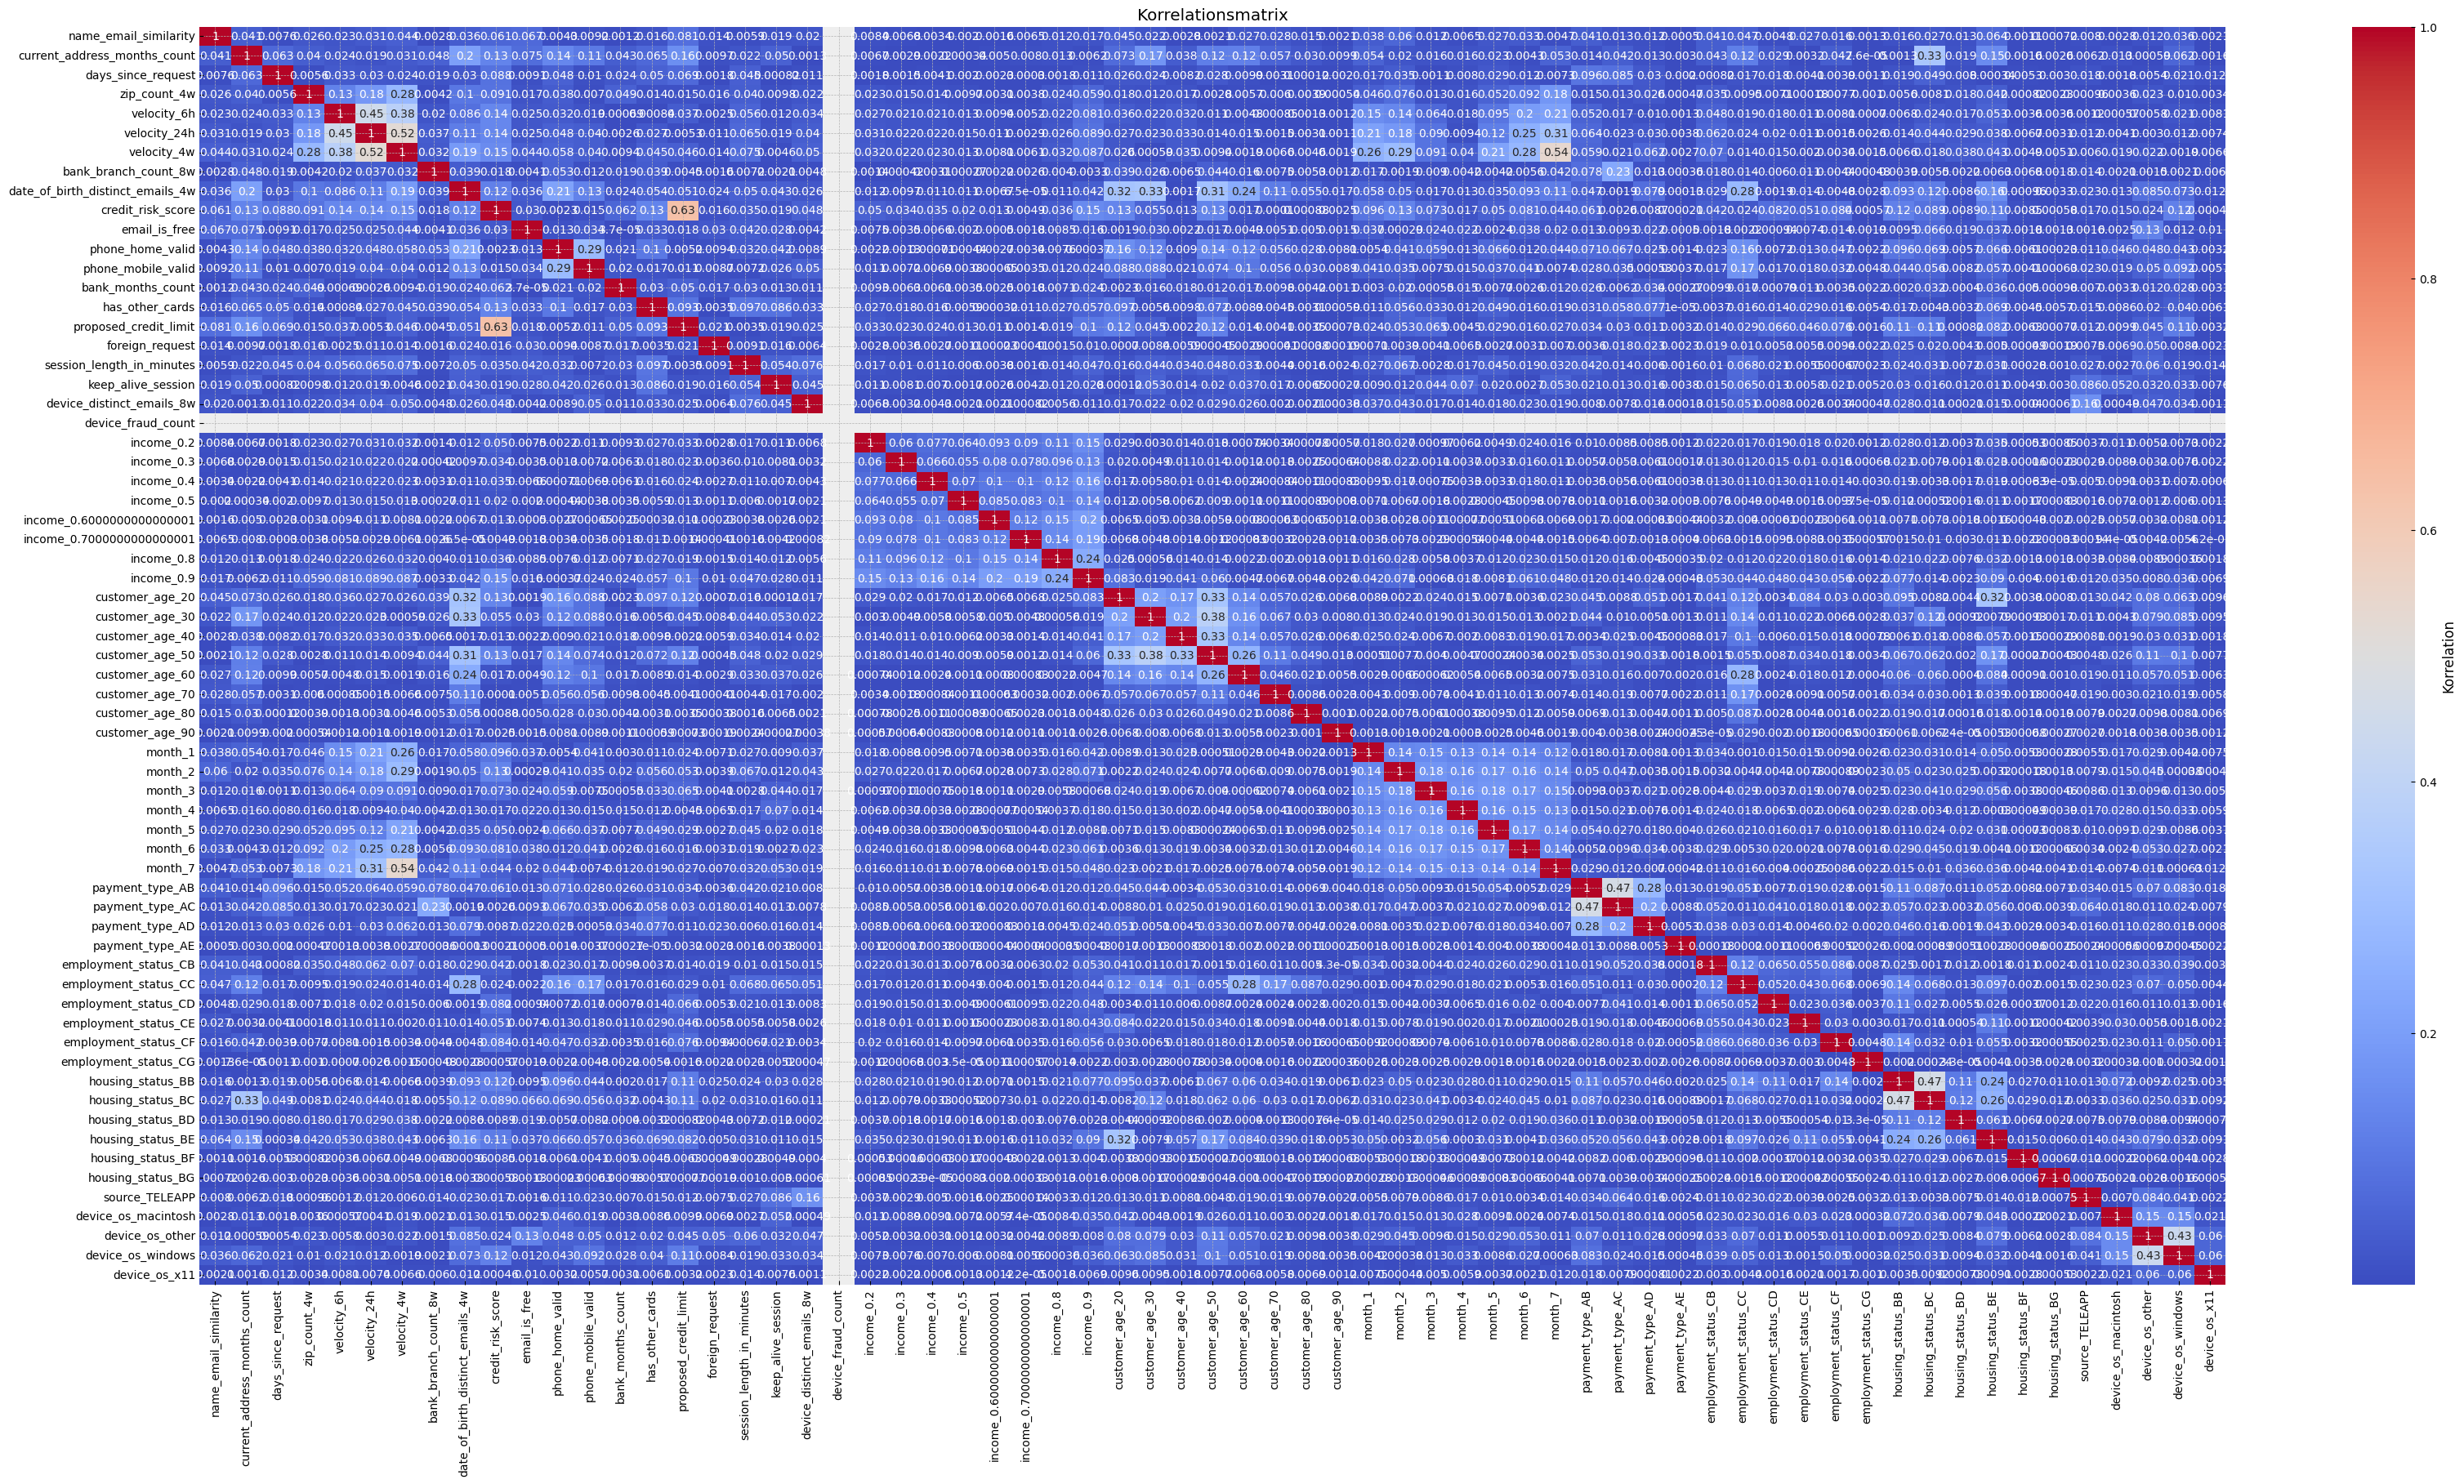

In [22]:
# Korrelation berechnen
corr_matrix = X_logreg.corr().abs() # abs() sehr wichtig, da auch Negativkorrelationen möglich sind und diese sonst nicht vom Threshold weiter unten erfasst werden

# Heatmap zur visuellen Kontrolle
plt.figure(figsize=(40, 20))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, cbar_kws={'label': 'Korrelation'}) # annot = True schreibt Werte in die Kästchen, cbar_kws={'label': 'Korrelation'} labeled die Skala rechts
plt.title("Korrelationsmatrix")
plt.show()

In [23]:
# untere oder obere Dreiecksmatrix auswählen (in diesem Fall die untere)
untere = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(bool))

# stark korrelierte Features identifizieren
threshold = 0.8 # Threshold  für Korrelation wählen...je näher an 1 desto höher
to_drop = [column for column in untere.columns if any(untere[column] > threshold)]
print("Features mit starker Korrelation über threshold:", to_drop)

Features mit starker Korrelation über threshold: []


In [24]:
# Features mit hoher Korrelation entfernen

X_logreg = X_logreg.drop(columns=to_drop)
print("Neue Form des DataFrames:", X.shape)

Neue Form des DataFrames: (1000000, 65)


## Varianz berechnen und Features mit niedriger Varianz (viele gleiche Werte) entfernen, da kein Einfluss auf Modell und mehr Rechenleistung nötig

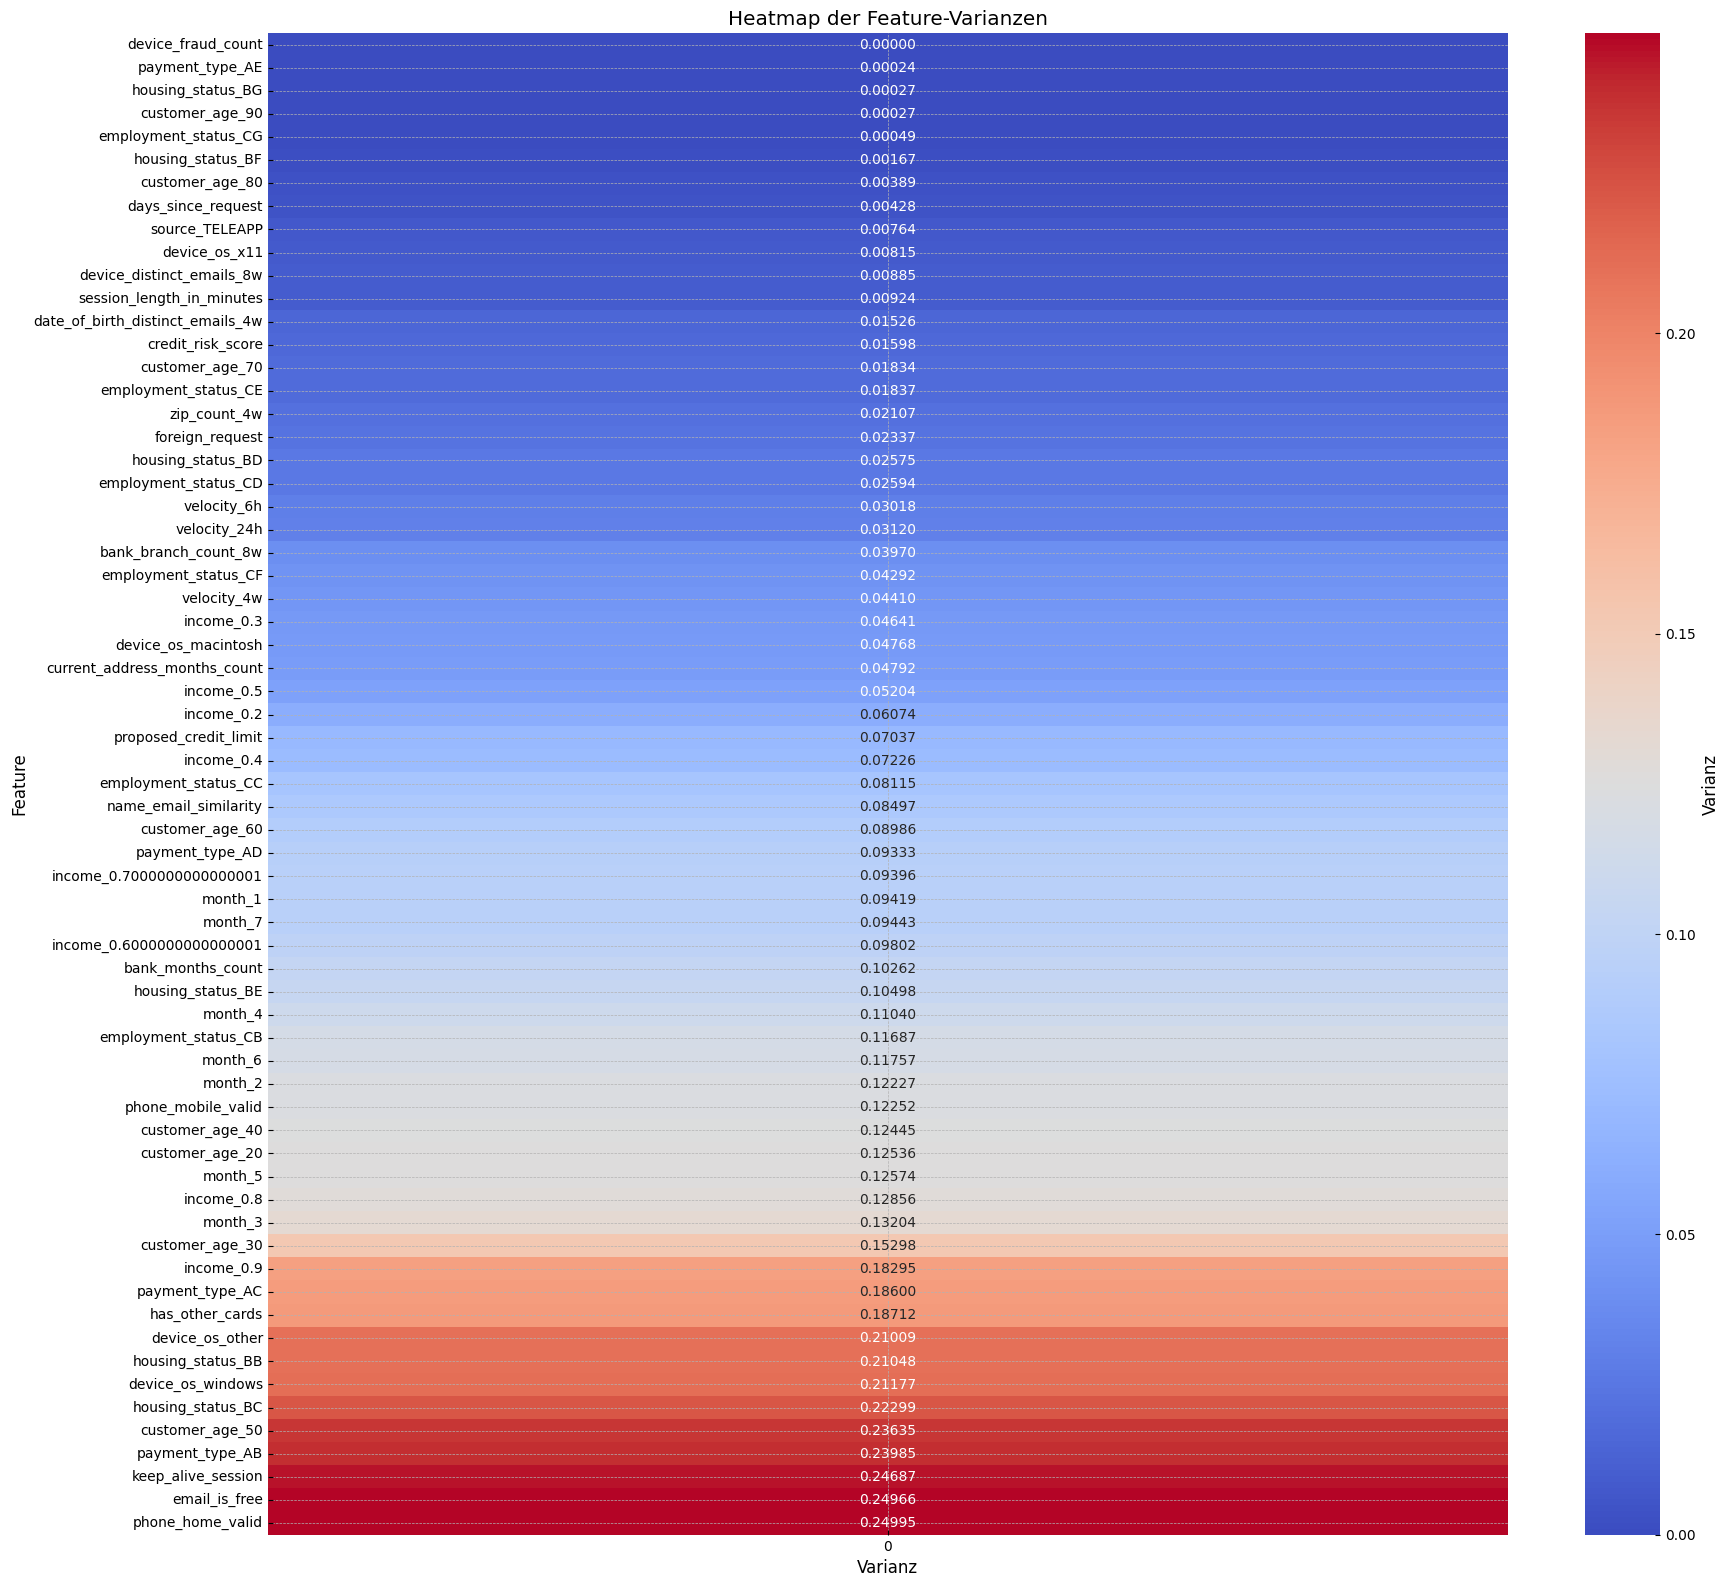

In [25]:
# Varianz aller Feature berechnen
variances = X_logreg.var().sort_values()

# Als Heatmap darstellen
plt.figure(figsize=(20, len(X_logreg.columns)*0.3))  # Höhe abhängig von Anzahl Features
sns.heatmap(variances.to_frame(), annot=True, fmt=".5f", cmap="coolwarm", cbar_kws={'label': 'Varianz'}, ) # annot = True schreibt Werte in die Kästchen, 
# fmt=".5f" zeigt Werte im Heatmap nur bis 5 Dezimalstellen für bessere Lesbarkeit an
# cbar_kws={'label': 'Varianz'} labeled die Skala rechts

plt.title("Heatmap der Feature-Varianzen")
plt.xlabel("Varianz")
plt.ylabel("Feature")
plt.show()

In [26]:
# Automatisierte Varianzerkennung mit VarianceThreshold: Entfernt Features, deren Varianz unter einem Schwellwert liegt
sel = VarianceThreshold(threshold=0.01)  # Nur filter für die Daten, z. B. 0.01 = 1% Varianz, bedeutet es werden alle Spalten entfernt, bei denen eine Klasse 99% vorkommt
sel.fit_transform(X) # berechnet die Varianz jedes Features im data frame, verändert Daten nicht

# gibt behaltene Spalten aus
kept_columns = X.columns[sel.get_support()]

# gibt gelöschte Spalten aus
removed_columns = X.columns[~sel.get_support()]

#speichert die behaltenen Feature über Threshold in DataFrame
X_logreg = X_logreg[kept_columns]

#print("Behaltene Spalten (über Threshold):")
#print(list(kept_columns))

print("\n Entfernte Spalten (unter Threshold):")
print(list(removed_columns))


 Entfernte Spalten (unter Threshold):
['days_since_request', 'session_length_in_minutes', 'device_distinct_emails_8w', 'device_fraud_count', 'customer_age_80', 'customer_age_90', 'payment_type_AE', 'employment_status_CG', 'housing_status_BF', 'housing_status_BG', 'source_TELEAPP', 'device_os_x11']


## Train-Test-Split mit kleinem Datensatz für schnelleres Training und Tuning

In [27]:
# Zuerst 10% der Daten ziehen (stratifiziert nach y)
X_small, _, y_small, _ = train_test_split(
    X_logreg, y_logreg, train_size=0.1, stratify=y, random_state=42
)

# Dann normalen Train/Test Split innerhalb der 10%
X_logreg_train, X_logreg_test, y_logreg_train, y_logreg_test = train_test_split(
    X_small, y_small,
    test_size=0.3,       # 30% Test innerhalb der 10%
    stratify=y_small,    # Klassenverteilung bleibt erhalten
    random_state=RANDOM_STATE
)

## GridSearch mit Pipeline und anschließendes Fitten

In [28]:
# Vorbereitung der Daten mit Pipeline, eine Pipeline kann für sehr viele Modelle genutzt werden und arbeitet die verschiedenen Schritte ab
pipe_log = Pipeline([
    ('smote', None), 
    ("clf", LogisticRegression(max_iter=100))
    ])

grid_search_log = {
    "smote": [BorderlineSMOTE(random_state=RANDOM_STATE), SMOTE(random_state=RANDOM_STATE), "passthrough"],
    "clf__penalty": ["L1", "l2"], # Regularisierung, l1 für Lasso und l2 für Ridge
    "clf__solver": ["liblinear", "saga"],
    "clf__class_weight": ["balanced", None], # balanced: automatische Anpassung der Gewichte an die Klassenhäufigkeit, jede Klasse bekommt ein Gewicht umgekehrt proportional zu ihrer Häufigkeit, setzt Gewicht für Fraud hoch und für Fraud nicht runter
    "clf__C": [0.001, 0.01, 0.1, 3, 5, 10]
}

# l1 für Lasso: Setzt manche Feature direkt auf 0 und entfernt sie somit, automatische Feature Selektion, starke Feature bleiben, schwache werden gelöscht
# l2 für Ridge: Strafterm für Koeffizienten, große Koeffizienten werden mehr bestraft, alle Koeffizienten werden kleiner, keiner wird exakt 0, starke Features bleiben, schwache werden reduziert

#erhält im Gegensatz zu kFold die die Klassenverteilung in jedem Fold, also proportional wie im gesamten Datensatz.(also wie bei stratify=y, nur für alle 5 cvs)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

model_log = GridSearchCV(
    pipe_log,
    grid_search_log,
    cv = cv, # macht 5 cross validation splits
    scoring=["f1", "precision", "recall", "roc_auc"],
    refit="roc_auc" # gibt auch die anderen scores aus, beste Hyperparameterkombination wird aber nach roc_auc score ausgewählt
)

In [29]:
model_log.fit(X_logreg_train, y_logreg_train)

C:\Users\MLA6FE\.conda\envs\graduate\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\MLA6FE\.conda\envs\graduate\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\MLA6FE\.conda\envs\graduate\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\MLA6FE\.conda\envs\graduate\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\MLA6FE\.conda\envs\graduate\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\MLA6FE\.conda\envs\graduate\lib\site-pack

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('smote', None),
                                       ('clf', LogisticRegression())]),
             param_grid={'clf__C': [0.001, 0.01, 0.1, 3, 5, 10],
                         'clf__class_weight': ['balanced', None],
                         'clf__penalty': ['L1', 'l2'],
                         'clf__solver': ['liblinear', 'saga'],
                         'smote': [BorderlineSMOTE(random_state=42),
                                   SMOTE(random_state=42), 'passthrough']},
             refit='roc_auc', scoring=['f1', 'precision', 'recall', 'roc_auc'])

## Scores der mesten Parametervariation sowie die besten Hyperparameter

In [30]:
best_idx = model_log.best_index_ # holt den Index der besten Kombination von Hyperparametern aus der GridSearch

print("\nScores der besten Parameterkombination:")
print("F1:",        model_log.cv_results_["mean_test_f1"][best_idx]) # mittleren F1-Score der besten Parameterkombination aus den Cross Validation Ergebnissen
print("Precision:", model_log.cv_results_["mean_test_precision"][best_idx])
print("Recall:",    model_log.cv_results_["mean_test_recall"][best_idx])
print("ROC-AUC:",   model_log.cv_results_["mean_test_roc_auc"][best_idx])
print("Best hyperparameter:", model_log.best_params_)


Scores der besten Parameterkombination:
F1: 0.012787849093581577
Precision: 0.5
Recall: 0.006476749057394218
ROC-AUC: 0.8564029912356782
Best hyperparameter: {'clf__C': 3, 'clf__class_weight': None, 'clf__penalty': 'l2', 'clf__solver': 'liblinear', 'smote': 'passthrough'}


## Laden aller Daten und übergeben der besten Parameter, dann nochmal Fitten

In [31]:
# Aufteilen der Daten in Train und Testdaten
X_logreg_train, X_logreg_test, y_logreg_train, y_logreg_test = train_test_split(X_logreg, y_logreg, test_size=0.30, stratify=y)
# stratify=y sorgt dafür, dass die Anteile der Klassen in y im Trainings- und Testset gleich bleiben. 0: 98.897% und 1: 1.103% in train und test-Daten.
# Bei stark unbalancierten Daten mit geringer Wahrscheinlichkeit einer Klasse wichtig, ohne stratify=y könnte es zufällig passieren, dass im Testset gar keine oder nur sehr wenige Klasse 1 ennthalten sind

In [32]:
best_log = model_log.best_estimator_

In [33]:
best_log.fit(X_logreg_train, y_logreg_train)

Pipeline(steps=[('smote', 'passthrough'),
                ('clf', LogisticRegression(C=3, solver='liblinear'))])

## Precision-Recall Kurve vs. Threshold anzeigen, um evtl. besseren Threshold zu bestimmen

Threshold bei Recall ~75 %: 0.012713987475514879
Threshold bei Schnittpunkt: 0.12061062270643759


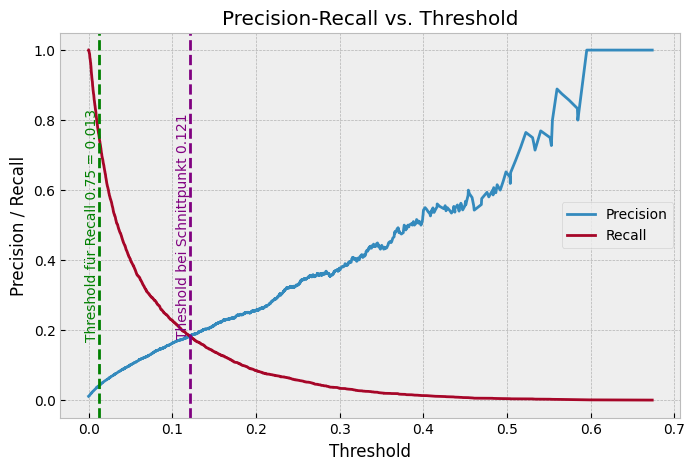

In [34]:
# Präzision: Von allen Fällen, die das Modell als positiv vorhergesagt hat, wie viele sind tatsächlich positiv?
# Recall: Von allen tatsächlich positiven Fällen, wie viele erkennt das Modell korrekt?

# Wahrscheinlichkeiten für Klasse 1
y_pred_prob = best_log.predict_proba(X_logreg_test)[:, 1] # gibt nur Wahrscheinlichkeit der positiven Klasse zurück (1)

# Precision, Recall und Thresholds berechnen
precision, recall, thresholds = precision_recall_curve(y_logreg_test, y_pred_prob)

recall_definieren = 0.75

# Threshold mit Recall am nächsten zu "recall_definieren" bestimmen
idx = np.argmin(np.abs(recall[:-1] - recall_definieren))
threshold_approx = thresholds[idx]

# Precision, Recall haben ein Element mehr als thresholds → kürzen
prec = precision[:-1]
rec = recall[:-1]

# Differenz zwischen Precision und Recall
diff = np.abs(prec - rec)

# Index des kleinsten Abstands → hier schneiden sie sich
idx_intersection = np.argmin(diff)

# Werte am Schnittpunkt
threshold_intersection = thresholds[idx_intersection]

# Plot
plt.figure(figsize=(8,5))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')

# Vertikale Linie für den definierten Threshold einfügen
plt.axvline(x=threshold_approx, color='green', linestyle='--', linewidth=2)

# Textbeschriftung
plt.text(threshold_approx, 0.5, f"Threshold für Recall {recall_definieren} = {threshold_approx:.3f}",
         rotation=90, va='center', ha='right', color='green')

# Vertikale Linie für Schnittpuntk von precision und recall
plt.axvline(x=threshold_intersection, color='purple', linestyle='--', linewidth=2)

# Textbeschriftung
plt.text(threshold_intersection, 0.5, f"Theshold bei Schnittpunkt {threshold_intersection:.3f}",
         rotation=90, va='center', ha='right', color='purple')

plt.xlabel('Threshold')
plt.ylabel('Precision / Recall')
plt.title('Precision-Recall vs. Threshold')
plt.legend()
plt.grid(True)

print(f"Threshold bei Recall ~{int(recall_definieren*100)} %:", threshold_approx)
print("Threshold bei Schnittpunkt:", threshold_intersection)

plt.show()

# der Schnittpunkt ist der F1-Score mit bestem Verhältnis von Precision und Recall, hier lässt sich auch der zugehörige Threshold ablesen

## Predictions/Vorhersagen ermitteln und ggf. Threshold anpassen

In [35]:
# Wahrscheinlichkeiten für die positive Klasse
probs_train = best_log.predict_proba(X_logreg_train)[:, 1]
probs_test = best_log.predict_proba(X_logreg_test)[:, 1]

# Eigenen Threshold anwenden, z.B. 0.3
threshold = threshold_approx # standard Threshold beträgt 0.5 bei sigmoid function
y_train_predict = (probs_train >= threshold).astype(int) # wandelt Wahrscheinlichkeiten in 0 und 1 um mit definiertem threshold
y_test_predict = (probs_test >= threshold).astype(int) # wandelt Wahrscheinlichkeiten in 0 und 1 um mit definiertem threshold

## Confusion Matrix und Classification Report für Train- und Test-Daten

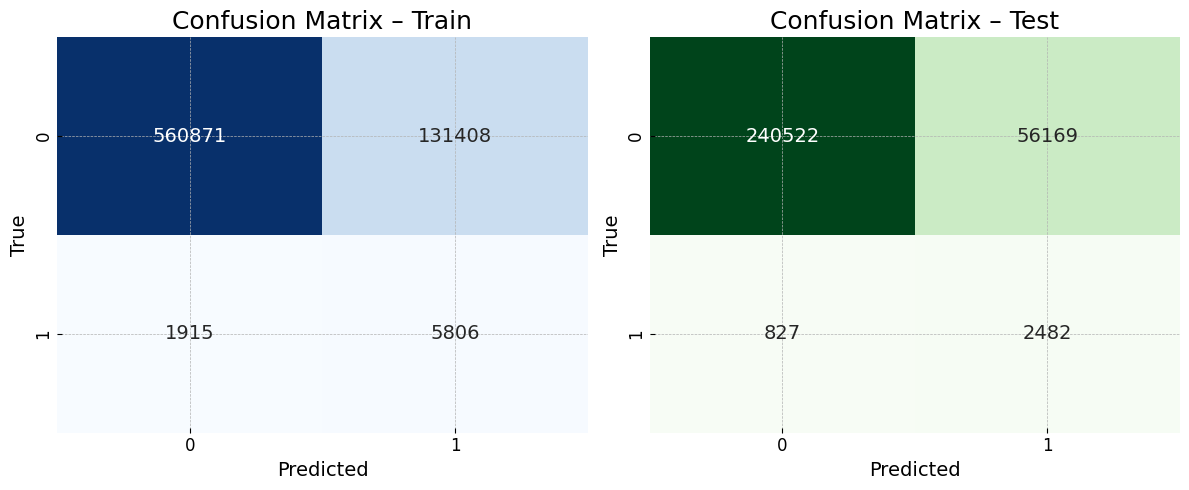


--- TRAIN SCORES ---
ROC-AUC: 0.8611852610176044
              precision    recall  f1-score   support

           0       1.00      0.81      0.89    692279
           1       0.04      0.75      0.08      7721

    accuracy                           0.81    700000
   macro avg       0.52      0.78      0.49    700000
weighted avg       0.99      0.81      0.88    700000


--- TEST SCORES ---
ROC-AUC: 0.8599760587445129
              precision    recall  f1-score   support

           0       1.00      0.81      0.89    296691
           1       0.04      0.75      0.08      3309

    accuracy                           0.81    300000
   macro avg       0.52      0.78      0.49    300000
weighted avg       0.99      0.81      0.89    300000



In [36]:
# Confusion Matrices
cm_train = confusion_matrix(y_logreg_train, y_train_predict)
cm_test = confusion_matrix(y_logreg_test, y_test_predict)

# Plot: Train und Test nebeneinander
plt.figure(figsize=(12,5))

# Train
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap="Blues",
            annot_kws={"size": 14}, cbar=False)
plt.title("Confusion Matrix – Train", fontsize=18)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Test
plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap="Greens",
            annot_kws={"size": 14}, cbar=False)
plt.title("Confusion Matrix – Test", fontsize=18)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

# Scores
print("\n--- TRAIN SCORES ---")
print("ROC-AUC:", roc_auc_score(y_logreg_train, best_log.predict_proba(X_logreg_train)[:, 1]))
print(classification_report(y_logreg_train, y_train_predict))

print("\n--- TEST SCORES ---")
print("ROC-AUC:", roc_auc_score(y_logreg_test, best_log.predict_proba(X_logreg_test)[:, 1]))
print(classification_report(y_logreg_test, y_test_predict))

## Decision Trees

In [37]:
# Vorbereitung der Daten
X_tree = X.copy()
y_tree = y.copy()

## Train-Test-Split mit kleinem Datensatz für schnelleres Training und Tuning

In [38]:
# Zuerst 10% der Daten ziehen (stratifiziert nach y)
X_small, _, y_small, _ = train_test_split(
    X_tree, y_tree, train_size=0.1, stratify=y, random_state=42
)

# Dann normalen Train/Test Split innerhalb der 10%
X_tree_train, X_tree_test, y_tree_train, y_tree_test = train_test_split(
    X_small, y_small,
    test_size=0.3,       # 30% Test innerhalb der 10%
    stratify=y_small,    # Klassenverteilung bleibt erhalten
    random_state=RANDOM_STATE
)

## Gewichtung für XGBoost und LightGBM bestimmen

In [39]:
# scale_pos_weight für XGBoost/LightGBM = (#neg)/(#pos) für die beste Gewichtung
n_pos = np.sum(y_tree_train == 1)
n_neg = np.sum(y_tree_train == 0)
scale_pos_weight = n_neg / max(1, n_pos)
print("scale_pos_weight (neg/pos):", scale_pos_weight)

scale_pos_weight (neg/pos): 89.67357512953367


## Decision Trees und Hyperparametervariationen für GridSearch festlegen

In [40]:
# Modelle + Grids (Pipeline nur mit Klassifier)
models_and_grids = {
    '''
    "DecisionTree": {
        "estimator": Pipeline([
            ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE))
        ]),
        "param_grid": {
            "clf__criterion": ["gini", "entropy"],
            "clf__max_depth": [5, 10, 20, None],
            "clf__min_samples_leaf": [1, 5, 10, 20],
            "clf__class_weight": [None, "balanced"]
        }
    },
    "RandomForest": {
        "estimator": Pipeline([
            ("clf", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
        ]),
        "param_grid": {
            "clf__n_estimators": [100, 300],
            "clf__max_depth": [3, 5, 10],
            "clf__min_samples_leaf": [1, 5, 10, 20],
            "clf__class_weight": [None, "balanced", "balanced_subsample"]
        }
    },
    "GradientBoosting": {
        "estimator": Pipeline([
            ("clf", GradientBoostingClassifier(random_state=RANDOM_STATE))
        ]),
        "param_grid": {
            "clf__n_estimators": [100, 300],
            "clf__learning_rate": [0.05, 0.1, 0.3, 0.5],
            "clf__max_depth": [3, 5, 10],
            "clf__min_samples_leaf": [1, 3, 5]
        }
    },
    '''
    "XGBoost": {
        "estimator": Pipeline([
            ("clf", xgb.XGBClassifier(
                random_state=RANDOM_STATE,
                use_label_encoder=False,
                eval_metric="logloss",
                n_jobs=-1
            ))
        ]),
        "param_grid": {
            "clf__n_estimators": [100, 300],
            "clf__max_depth": [3, 5],
            "clf__learning_rate": [0.05, 0.1, 0.3, 0.5],
            "clf__scale_pos_weight": [scale_pos_weight, 1.0]
        }
    },
    "LightGBM": {
        "estimator": Pipeline([
            ("clf", LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1))
        ]),
        "param_grid": {
            "clf__n_estimators": [100, 300],
            "clf__num_leaves": [3, 6],
            "clf__max_depth": [3, 5, 10],
            "clf__learning_rate": [0.05, 0.1, 0.3, 0.5],
            "clf__scale_pos_weight": [scale_pos_weight, 1.0]
        }
    }
}

## GridSearch durchführen auf ROC-AUC und andere Scores zur Validierung errechnen, beste Werte für jeden Baum ausgeben

In [41]:
# CV und Scoring
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

best_results = {}

for tree, model_hyp in models_and_grids.items(): # Schleife über das oben definierte Dictionary: tree = key, benannten DecisionTree und model_hyp = Model # Hyperparametergrid zum key
    grid_search = GridSearchCV(
        estimator=model_hyp["estimator"], # übernimmt den estimator, hier den classifier clf aus pipeline
        param_grid=model_hyp["param_grid"], # übernimmt die Hyperparamatervariationen
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1, # Nutzt alle CPU-Kerne, um schneller zu rechnen
        verbose=2, # gibt Fortschritt aus
        refit=True # speichert gleich gs.best_estimator_ mit dem besten Modell und den besten Hyperparameter, True ist der default-Wert 
    )
    grid_search.fit(X_tree_train, y_tree_train)
    best_tree = grid_search.best_estimator_ # wählt Modell aus mit dem besten scoring, hier f1 # Abrufen der besten Parametervariation aus dem fit und Übergabe an Pipeline

# Zusätzliche Scores auf dem Validation/Test-Set
    y_pred = best_tree.predict(X_tree_test)
    y_prob = best_tree.predict_proba(X_tree_test)[:, 1]

    precision = precision_score(y_tree_test, y_pred)
    recall = recall_score(y_tree_test, y_pred)
    auc = roc_auc_score(y_tree_test, y_prob)
    f1 = f1_score(y_tree_test, y_pred)

    # Alles im Dictionary speichern
    best_results[tree] = { # Erstelle Dictionary, in dem für jedes Modell die besten Parameter enthalten sind und der beste Score, sowei die zusätzlichen scores
        "best_roc_auc_cv": grid_search.best_score_,
        "best_params": grid_search.best_params_,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# Ausgabe
for tree, results in best_results.items():
    print(
        f"{tree:12} -> "
        f"ROC-AUC: {results['best_roc_auc_cv']:.4f}, "
        f"Precision: {results['precision']:.4f}, "
        f"Recall: {results['recall']:.4f}, "
        f"F1: {results['f1']:.4f}, "
        f"Params: {results['best_params']}"
    )

Fitting 5 folds for each of 32 candidates, totalling 160 fits


C:\Users\MLA6FE\.conda\envs\graduate\lib\site-packages\xgboost\training.py:199: UserWarning: [14:19:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 5 folds for each of 96 candidates, totalling 480 fits
[LightGBM] [Info] Number of positive: 772, number of negative: 69228
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2727
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.011029 -> initscore=-4.496176
[LightGBM] [Info] Start training from score -4.496176

    "DecisionTree": {
        "estimator": Pipeline([
            ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE))
        ]),
        "param_grid": {
            "clf__criterion": ["gini", "entropy"],
            "clf__max_depth": [5, 10, 20, None],
            "clf__min_samples_leaf": [1, 5, 10, 20],
            "clf__class_weight": [None, "balanced"]
        }
    }

## Darstellen der jeweils besten Ergebnisse der Bäume

C:\Users\MLA6FE\AppData\Local\Temp\ipykernel_9200\1271875330.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


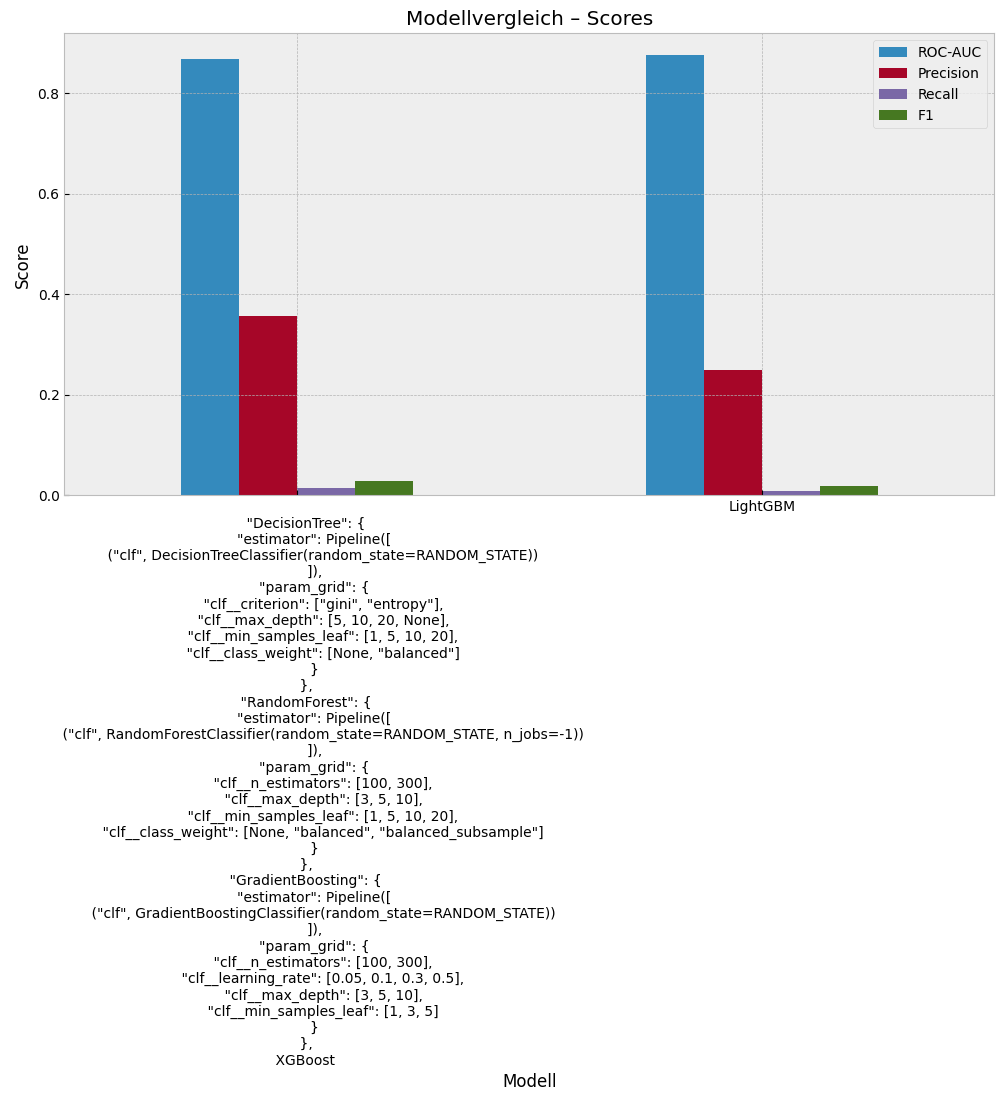

In [42]:
# Dictionary → DataFrame
df_results = pd.DataFrame.from_dict(best_results, orient="index")
# index ist z.B. "DecisionTree", "RandomForest" usw.

# Nur die Metriken plotten
metrics = ["best_roc_auc_cv", "precision", "recall", "f1"]

df_results[metrics].plot.bar(figsize=(12,6))
plt.title("Modellvergleich – Scores")
plt.ylabel("Score")
plt.xlabel("Modell")
plt.xticks(rotation=0)
plt.legend(["ROC-AUC", "Precision", "Recall", "F1"])
plt.tight_layout()
plt.show()

## Laden aller Daten und dann nochmal mit besten Klassifikator mit besten Hyperparametern fitten

In [43]:
# Aufteilen der Daten in Train und Testdaten
X_tree_train, X_tree_test, y_tree_train, y_tree_test = train_test_split(X_tree, y_tree, test_size=0.30, stratify=y)
# stratify=y sorgt dafür, dass die Anteile der Klassen in y im Trainings- und Testset gleich bleiben. 0: 98.897% und 1: 1.103% in train und test-Daten.
# Bei stark unbalancierten Daten mit geringer Wahrscheinlichkeit einer Klasse wichtig, ohne stratify=y könnte es zufällig passieren, dass im Testset gar keine oder nur sehr wenige Klasse 1 ennthalten sind

In [44]:
best_tree.fit(X_tree_train, y_tree_train)

[LightGBM] [Info] Number of positive: 7721, number of negative: 692279
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2734
[LightGBM] [Info] Number of data points in the train set: 700000, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.011030 -> initscore=-4.496045
[LightGBM] [Info] Start training from score -4.496045


Pipeline(steps=[('clf',
                 LGBMClassifier(max_depth=3, n_estimators=300, n_jobs=-1,
                                num_leaves=3, random_state=42,
                                scale_pos_weight=1.0))])

## ROC-Kurve, zeigt die Perfomance eines binären Klassifikators über alle Thresholds, der ROC_AUC Score ist die Fläche unter der Kurve

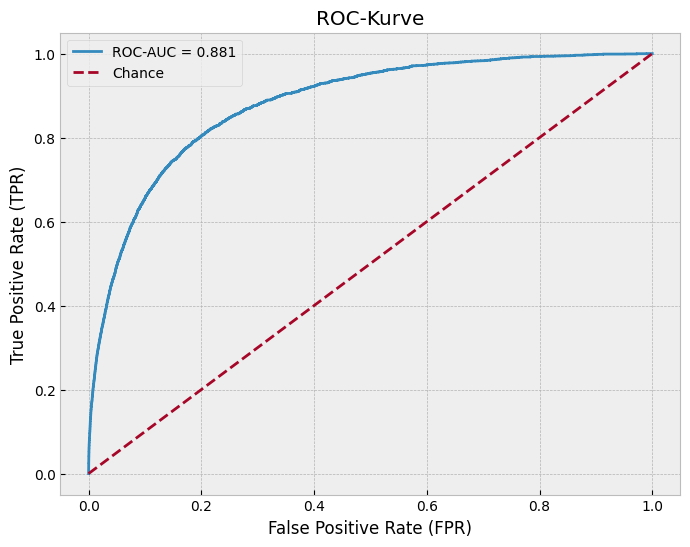

In [45]:
# Wahrscheinlichkeiten der positiven Klasse (1) für Testdaten
y_pred_prob = best_tree.predict_proba(X_tree_test)[:, 1]

# ROC-Werte berechnen
fpr, tpr, _ = roc_curve(y_tree_test, y_pred_prob)
roc_auc = roc_auc_score(y_tree_test, y_pred_prob)

# Plot
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, linewidth=2, label=f"ROC-AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', label="Chance")  # Diagonale
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC-Kurve")
plt.legend()
plt.grid(True)
plt.show()

## Precision-Recall Kurve vs. Threshold anzeigen, um evtl. besseren Threshold zu bestimmen

Threshold bei Recall ~75 %: 0.014824699987878253
Threshold bei Schnittpunkt: 0.11517628557537497


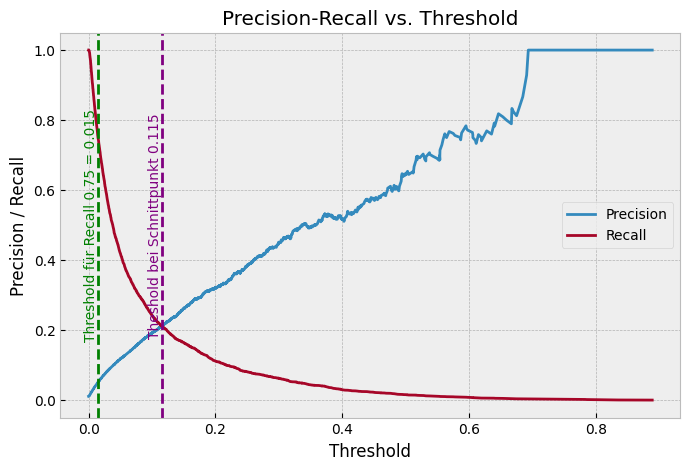

In [46]:
# Präzision: Von allen Fällen, die das Modell als positiv vorhergesagt hat, wie viele sind tatsächlich positiv?
# Recall: Von allen tatsächlich positiven Fällen, wie viele erkennt das Modell korrekt?

# Wahrscheinlichkeiten für Klasse 1
y_pred_prob = best_tree.predict_proba(X_tree_test)[:, 1] # gibt nur Wahrscheinlichkeit der positiven Klasse zurück (1)

# Precision, Recall und Thresholds berechnen
precision, recall, thresholds = precision_recall_curve(y_tree_test, y_pred_prob)

recall_definieren = 0.75

# Threshold mit Recall am nächsten zu "recall_definieren" bestimmen
idx = np.argmin(np.abs(recall[:-1] - recall_definieren))
threshold_approx = thresholds[idx]

# Precision, Recall haben ein Element mehr als thresholds → kürzen
prec = precision[:-1]
rec = recall[:-1]

# Differenz zwischen Precision und Recall
diff = np.abs(prec - rec)

# Index des kleinsten Abstands → hier schneiden sie sich
idx_intersection = np.argmin(diff)

# Werte am Schnittpunkt
threshold_intersection = thresholds[idx_intersection]

# Plot
plt.figure(figsize=(8,5))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')

# Vertikale Linie für den definierten Threshold einfügen
plt.axvline(x=threshold_approx, color='green', linestyle='--', linewidth=2)

# Textbeschriftung
plt.text(threshold_approx, 0.5, f"Threshold für Recall {recall_definieren} = {threshold_approx:.3f}",
         rotation=90, va='center', ha='right', color='green')

# Vertikale Linie für Schnittpuntk von precision und recall
plt.axvline(x=threshold_intersection, color='purple', linestyle='--', linewidth=2)

# Textbeschriftung
plt.text(threshold_intersection, 0.5, f"Theshold bei Schnittpunkt {threshold_intersection:.3f}",
         rotation=90, va='center', ha='right', color='purple')

plt.xlabel('Threshold')
plt.ylabel('Precision / Recall')
plt.title('Precision-Recall vs. Threshold')
plt.legend()
plt.grid(True)

print(f"Threshold bei Recall ~{int(recall_definieren*100)} %:", threshold_approx)
print("Threshold bei Schnittpunkt:", threshold_intersection)

plt.show()

# der Schnittpunkt ist der F1-Score mit bestem Verhältnis von Precision und Recall, hier lässt sich auch der zugehörige Threshold ablesen

## Precision-Recall Kurve anzeigen, um zu sehen wie gut das Modell ist

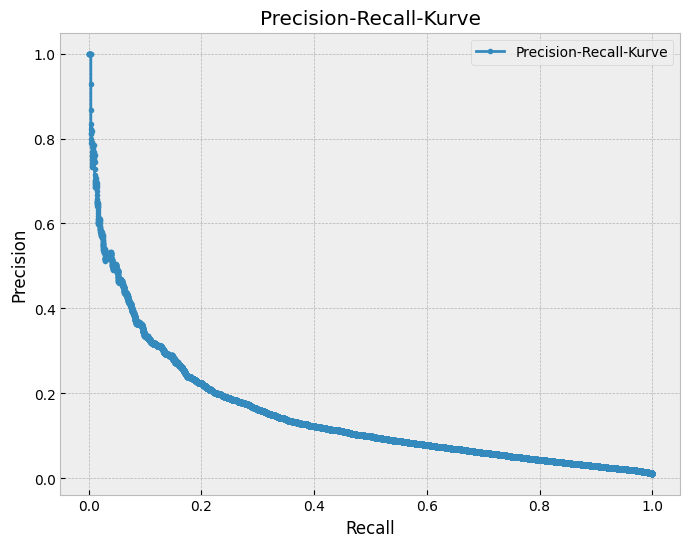

In [47]:
# Präzision: Von allen Fällen, die das Modell als positiv vorhergesagt hat, wie viele sind tatsächlich positiv?
# Recall: Von allen tatsächlich positiven Fällen, wie viele erkennt das Modell korrekt?
# "average_precision" ist die Fläche unter der Kurve: 1 = perfektes Modell, das alle Positiven erkennt ohne False Positives, 0.5 = zufälliges Modell (nur grob bei stark unausgeglichenen Klassen).

precision, recall, _ = precision_recall_curve(y_tree_test, y_pred_prob)

# Plot
plt.figure(figsize=(8,6))
plt.plot(recall, precision, marker='.', label='Precision-Recall-Kurve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall-Kurve')
plt.legend()
plt.grid(True)
plt.show()

## F1-Kurve, um Theshold für maximalen F1-Wert zu ermitteln

Bester Threshold: 0.09
Bester F1-Score: 0.21524771524771524


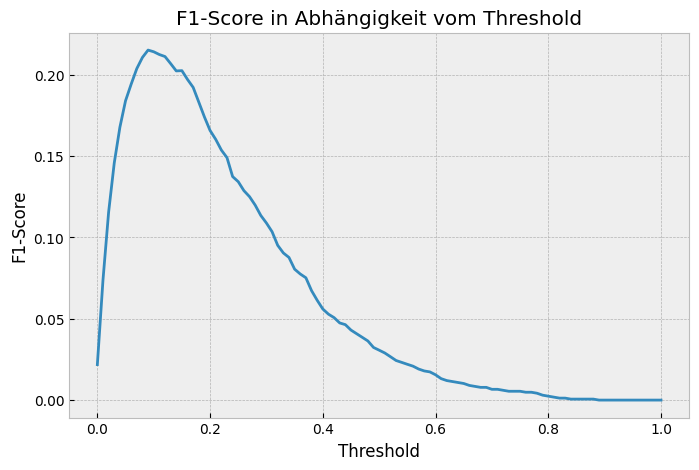

In [48]:
# Wahrscheinlichkeiten holen für die positive Klasse 1
y_proba = best_tree.predict_proba(X_tree_test)[:, 1]

# Theshold von 0-1 testen
thresholds = np.arange(0.0, 1.01, 0.01) # erzeugt eine Liste mit Werten von 0.0 - 1.0 in 0.01 Schritten
f1_scores = [] # definiere leere Liste

for t in thresholds: # geht jeden Wert in threshold durch
    y_pred = (y_proba >= t).astype(int) # gibt für jeden threshold Wert True oder False zurück, je nachdem pb y_proba größer oder kleiner threshold
    f1_scores.append(f1_score(y_tree_test, y_pred)) # gibt für jedne threshold f1 Wert aus

# Besten Threshold bestimmen
best_index = np.argmax(f1_scores) # gibt den Maximalwert aus
best_threshold = thresholds[best_index] # gibt dazu den dazugehörigen threshold aus
best_f1 = f1_scores[best_index] # gibt den besten f1 score aus

print("Bester Threshold:", best_threshold)
print("Bester F1-Score:", best_f1)

# f1-Verlauf als Grafik
plt.figure(figsize=(8,5))
plt.plot(thresholds, f1_scores)
plt.xlabel("Threshold")
plt.ylabel("F1-Score")
plt.title("F1-Score in Abhängigkeit vom Threshold")
plt.grid(True)
plt.show()

## Predictions/Vorhersagen ermitteln und ggf. Threshold anpassen

In [49]:
# Wahrscheinlichkeiten für die positive Klasse
probs_train = best_tree.predict_proba(X_tree_train)[:, 1]
probs_test = best_tree.predict_proba(X_tree_test)[:, 1]

# Eigenen Threshold anwenden, z.B. 0.3
threshold = threshold_approx # standard Threshold beträgt 0.5 bei sigmoid function
y_train_predict = (probs_train >= threshold).astype(int) # wandelt Wahrscheinlichkeiten in 0 und 1 um mit definiertem threshold
y_test_predict = (probs_test >= threshold).astype(int) # wandelt Wahrscheinlichkeiten in 0 und 1 um mit definiertem threshold

## Sensitivity vs. Specificy (bei zuvor definiertem Threshold

C:\Users\MLA6FE\AppData\Local\Temp\ipykernel_9200\355353379.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metric', y='Value', data=metrics_df, palette='Blues')


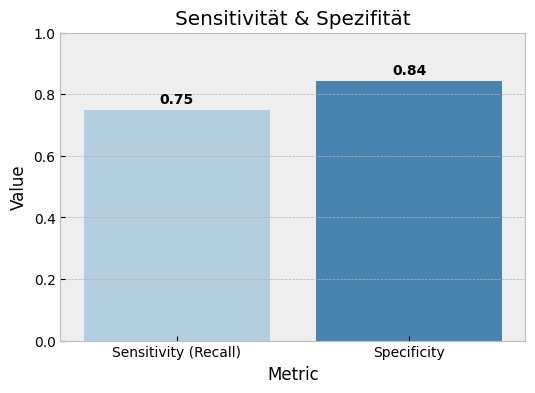

In [50]:
# Sensitivity (Sensitivität) = Wie gut erkennt das Modell die Positiven (Betrug / Fälle / 1er)
# Beispiel bei 79 %: Von allen tatsächlich positiven Fällen werden 79 % vom Modell richtig erkannt, 21 % übersieht das Modell und sind damit falsch negativ
# Specificity (Spezifität) = Wie gut erkennt das Modell die Negativen (Nicht-Betrug / Nicht-Fälle / 0er)
# Beispiel bei 82 %: Von allen tatsächlich negativen Fällen werden 82 % vom Modell richtig erkannt, 18 % werden vom Modell falsch positiv eingestuft

# y_tree_test = wahre Labels
# y_test_predict = Vorhersagen (0/1)

# berechnet die confusion Matrix und speichert die Werte true negative, false positive, false negative und true positive in Variablen
cm = confusion_matrix(y_tree_test, y_test_predict)
tn, fp, fn, tp = cm.ravel()

# Berechnung der sensitivity und specificity
sensitivity = tp / (tp + fn)   # Recall
specificity = tn / (tn + fp)

# Speichern in einem DataFrame
metrics_df = pd.DataFrame({
    'Metric': ['Sensitivity (Recall)', 'Specificity'],
    'Value': [sensitivity, specificity]
})

# Darstellung als Plot
plt.figure(figsize=(6,4))
sns.barplot(x='Metric', y='Value', data=metrics_df, palette='Blues')
plt.ylim(0, 1)
plt.title('Sensitivität & Spezifität')
for i, v in enumerate(metrics_df['Value']):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()

## Confusion Matrix und Classification Report für Train- und Test-Daten

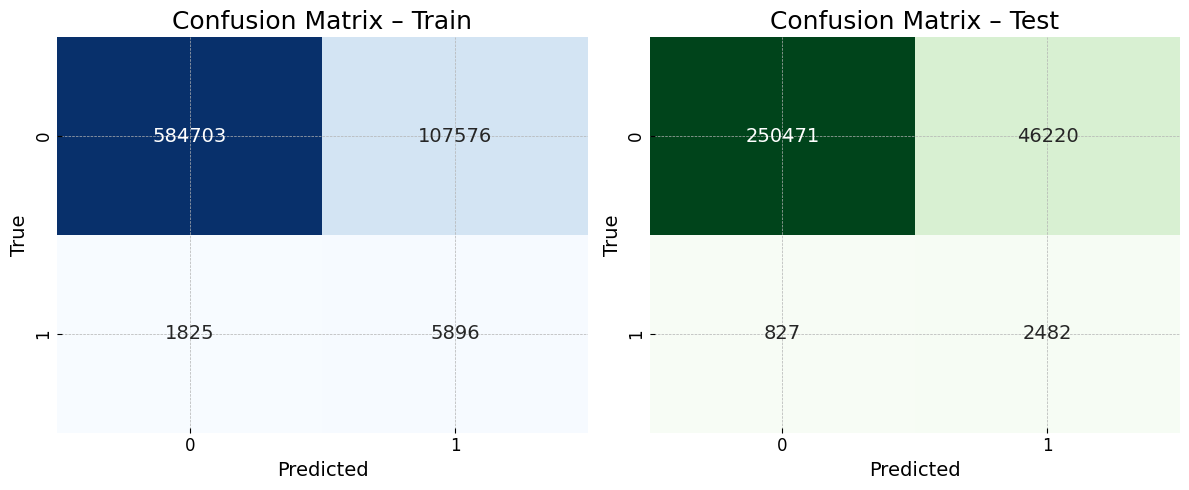


--- TRAIN SCORES ---
ROC-AUC: 0.8866250763835442
              precision    recall  f1-score   support

           0       1.00      0.84      0.91    692279
           1       0.05      0.76      0.10      7721

    accuracy                           0.84    700000
   macro avg       0.52      0.80      0.51    700000
weighted avg       0.99      0.84      0.91    700000


--- TEST SCORES ---
ROC-AUC: 0.8810275357745952
              precision    recall  f1-score   support

           0       1.00      0.84      0.91    296691
           1       0.05      0.75      0.10      3309

    accuracy                           0.84    300000
   macro avg       0.52      0.80      0.50    300000
weighted avg       0.99      0.84      0.91    300000



In [51]:
# Confusion Matrices
cm_train = confusion_matrix(y_tree_train, y_train_predict)
cm_test = confusion_matrix(y_tree_test, y_test_predict)

# Plot: Train und Test nebeneinander
plt.figure(figsize=(12,5))

# Train
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap="Blues",
            annot_kws={"size": 14}, cbar=False)
plt.title("Confusion Matrix – Train", fontsize=18)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Test
plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap="Greens",
            annot_kws={"size": 14}, cbar=False)
plt.title("Confusion Matrix – Test", fontsize=18)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

# Scores
print("\n--- TRAIN SCORES ---")
print("ROC-AUC:", roc_auc_score(y_tree_train, best_tree.predict_proba(X_tree_train)[:, 1]))
print(classification_report(y_tree_train, y_train_predict))

print("\n--- TEST SCORES ---")
print("ROC-AUC:", roc_auc_score(y_tree_test, best_tree.predict_proba(X_tree_test)[:, 1]))
print(classification_report(y_tree_test, y_test_predict))

## Neuronales Netz

In [52]:
# Vorbereitung der Daten
X_neuro = X.copy()
y_neuro = y.copy()

## Train Test Split aller Daten

In [53]:
# Aufteilen der Daten in Train und Testdaten
X_neuro_train, X_neuro_test, y_neuro_train, y_neuro_test = train_test_split(X_neuro, y_neuro, test_size=0.30, stratify=y)
# stratify=y sorgt dafür, dass die Anteile der Klassen in y im Trainings- und Testset gleich bleiben. 0: 98.897% und 1: 1.103% in train und test-Daten.
# Bei stark unbalancierten Daten mit geringer Wahrscheinlichkeit einer Klasse wichtig, ohne stratify=y könnte es zufällig passieren, dass im Testset gar keine oder nur sehr wenige Klasse 1 ennthalten sind

## Modell

In [59]:
# Gewichtung anpassen, wichtig bei stark ungleich verteilten Daten
classes = np.unique(y_neuro_train)
weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_neuro_train
)

class_weights = {cls: w for cls, w in zip(classes, weights)}
print("Class Weights:", class_weights)

# Beispiel-Ausgabe bei 99:1: {0: 0.505, 1: 49.5}

# Modell definieren
model_neuro = models.Sequential([
    layers.Input(shape=(X_neuro_train.shape[1],)),

    layers.Dense(64),
    layers.ReLU(),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(32),
    layers.ReLU(),
    layers.BatchNormalization(),
    layers.Dropout(0.15),

    layers.Dense(1, activation='sigmoid')
])

# Neuronen hochstarten und dann reduzieren, immer die Hälfte
# nicht mehr als 3 Zwischenschichten, da einfache Klassifikationsaufgabe


model_neuro.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
    loss="binary_crossentropy", # da binärer Zielwert 0 und 1
    metrics=["precision", "recall", "AUC"]  
)

model_neuro.summary()

# early stopping einbauen
early_stop = EarlyStopping(
    monitor='val_loss',       # worauf wir achten (oder 'loss' ohne Validation)
    patience=3,               # wie viele Verschlechterungen erlaubt sind
    mode='min',               # wir wollen den kleinsten Wert
    restore_best_weights=True # beste Gewichte wiederherstellen
)

# Training
history = model_neuro.fit(
    X_neuro_train,
    y_neuro_train,
    epochs=1000,
    batch_size=500,   # große Batch-Größe → schnell + stabil
    validation_data=(X_neuro_test, y_neuro_test),
    class_weight=class_weights,
    verbose=1,
    callbacks=[early_stop]
)

# Auswertung
y_pred_proba = model_neuro.predict(X_neuro_test).ravel()
y_pred = (y_pred_proba >= 0.5).astype(int)

print("\nClassification Report (Threshold=0.5):")
print(classification_report(y_neuro_test, y_pred))

Class Weights: {0: 0.5055765088930908, 1: 45.33091568449683}


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 64)                  │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,721 (26.25 KB)

 Trainable params: 6,529 (25.50 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/1000
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - AUC: 0.6637 - loss: 0.7054 - precision: 0.0167 - recall: 0.6905 - val_AUC: 0.7776 - val_loss: 0.7095 - val_precision: 0.0223 - val_recall: 0.7942
Epoch 2/1000
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - AUC: 0.8034 - loss: 0.5491 - precision: 0.0251 - recall: 0.7902 - val_AUC: 0.8246 - val_loss: 0.6020 - val_precision: 0.0287 - val_recall: 0.7966
Epoch 3/1000
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - AUC: 0.8309 - loss: 0.5104 - precision: 0.0307 - recall: 0.7871 - val_AUC: 0.8393 - val_loss: 0.5456 - val_precision: 0.0330 - val_recall: 0.7879
Epoch 4/1000
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - AUC: 0.8419 - loss: 0.4938 - precision: 0.0341 - recall: 0.7766 - val_AUC: 0.8464 - val_loss: 0.5152 - val_precision: 0.0356 - val_recall: 0.7833
Epoch 5/1000
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - AUC: 0.8486 - loss: 0.4842 - precision: 0.0359 - recall: 0.7736 - val_AUC: 0.8509 - val_loss: 0.4998 - val_precision: 0.0369 

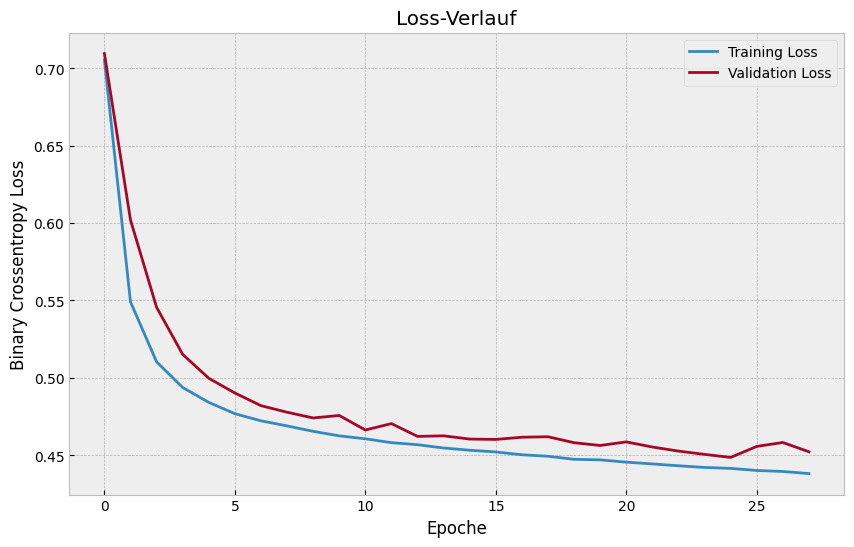

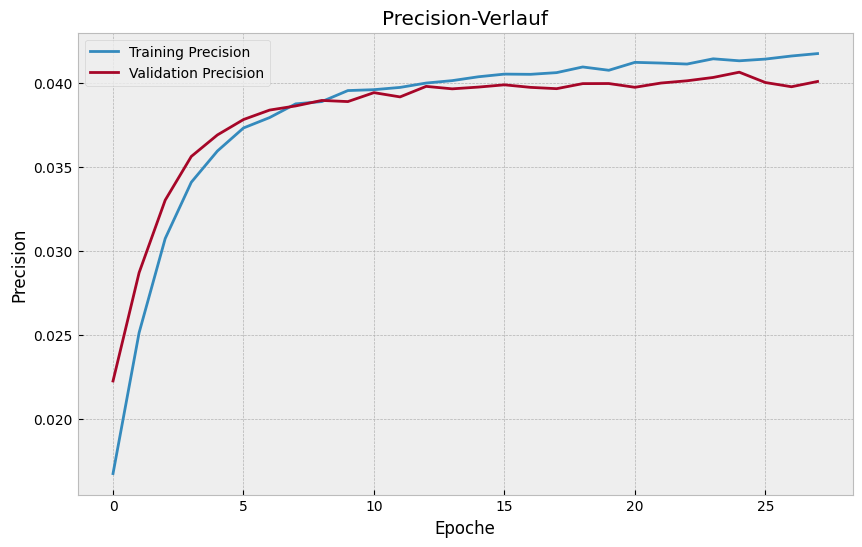

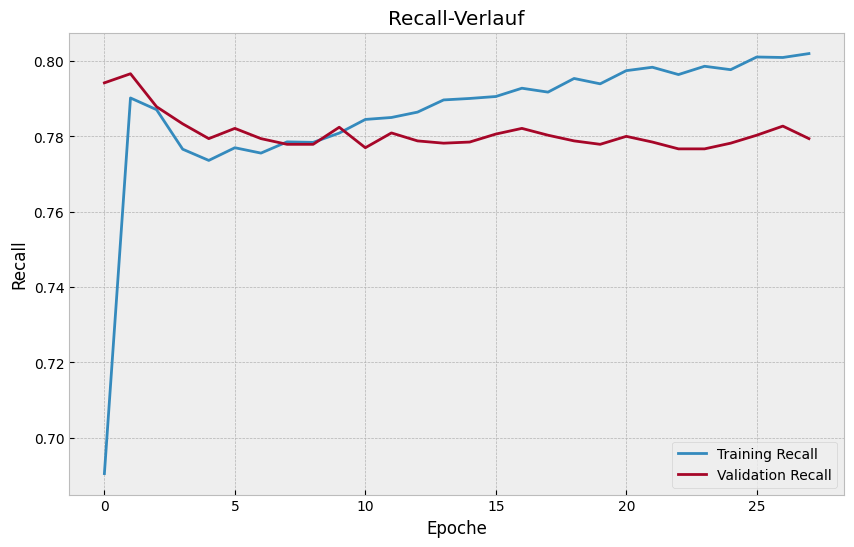

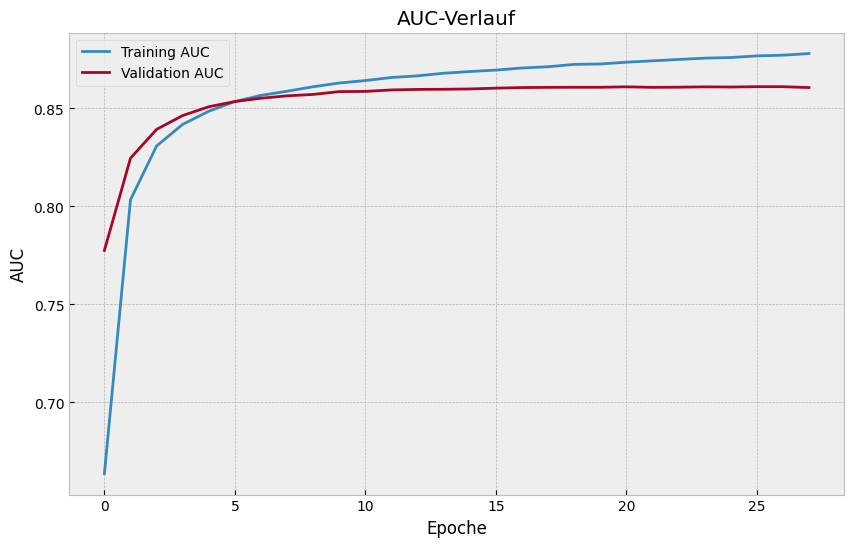

In [60]:
history_dict = history.history


# loss
plt.figure(figsize=(10, 6))
plt.plot(history_dict["loss"], label="Training Loss")
plt.plot(history_dict["val_loss"], label="Validation Loss")
plt.title("Loss-Verlauf")
plt.xlabel("Epoche")
plt.ylabel("Binary Crossentropy Loss")
plt.legend()
plt.grid(True)
plt.show()


# Precision
plt.figure(figsize=(10, 6))
plt.plot(history_dict["precision"], label="Training Precision")
plt.plot(history_dict["val_precision"], label="Validation Precision")
plt.title("Precision-Verlauf")
plt.xlabel("Epoche")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()

# Recall
plt.figure(figsize=(10, 6))
plt.plot(history_dict["recall"], label="Training Recall")
plt.plot(history_dict["val_recall"], label="Validation Recall")
plt.title("Recall-Verlauf")
plt.xlabel("Epoche")
plt.ylabel("Recall")
plt.legend()
plt.grid(True)
plt.show()

# ROC-AUC
plt.figure(figsize=(10, 6))
plt.plot(history_dict["AUC"], label="Training AUC")
plt.plot(history_dict["val_AUC"], label="Validation AUC")
plt.title("AUC-Verlauf")
plt.xlabel("Epoche")
plt.ylabel("AUC")
plt.legend()
plt.grid(True)
plt.show()

9375/9375 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
Threshold bei Recall ~75 %: 0.5371634
Threshold bei Schnittpunkt: 0.93534786


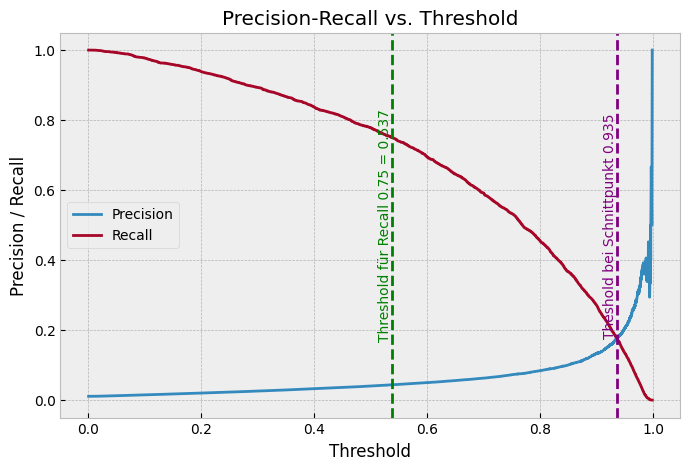

In [61]:
# Präzision: Von allen Fällen, die das Modell als positiv vorhergesagt hat, wie viele sind tatsächlich positiv?
# Recall: Von allen tatsächlich positiven Fällen, wie viele erkennt das Modell korrekt?

# Auswertung
y_pred_proba = model_neuro.predict(X_neuro_test).ravel() # Wahrscheinlichkeiten
y_pred = (y_pred_proba >= 0.5).astype(int) # Binäre Vorhersagen

# Precision, Recall und Thresholds berechnen
precision, recall, thresholds = precision_recall_curve(y_neuro_test, y_pred_proba)

recall_definieren = 0.75

# Threshold mit Recall am nächsten zu "recall_definieren" bestimmen
idx = np.argmin(np.abs(recall[:-1] - recall_definieren))
threshold_approx = thresholds[idx]

# Precision, Recall haben ein Element mehr als thresholds → kürzen
prec = precision[:-1]
rec = recall[:-1]

# Differenz zwischen Precision und Recall
diff = np.abs(prec - rec)

# Index des kleinsten Abstands → hier schneiden sie sich
idx_intersection = np.argmin(diff)

# Werte am Schnittpunkt
threshold_intersection = thresholds[idx_intersection]

# Plot
plt.figure(figsize=(8,5))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')

# Vertikale Linie für den definierten Threshold einfügen
plt.axvline(x=threshold_approx, color='green', linestyle='--', linewidth=2)

# Textbeschriftung
plt.text(threshold_approx, 0.5, f"Threshold für Recall {recall_definieren} = {threshold_approx:.3f}",
         rotation=90, va='center', ha='right', color='green')

# Vertikale Linie für Schnittpuntk von precision und recall
plt.axvline(x=threshold_intersection, color='purple', linestyle='--', linewidth=2)

# Textbeschriftung
plt.text(threshold_intersection, 0.5, f"Theshold bei Schnittpunkt {threshold_intersection:.3f}",
         rotation=90, va='center', ha='right', color='purple')

plt.xlabel('Threshold')
plt.ylabel('Precision / Recall')
plt.title('Precision-Recall vs. Threshold')
plt.legend()
plt.grid(True)

print(f"Threshold bei Recall ~{int(recall_definieren*100)} %:", threshold_approx)
print("Threshold bei Schnittpunkt:", threshold_intersection)

plt.show()

In [62]:
# Wahrscheinlichkeiten für die positive Klasse
probs_train = model_neuro.predict(X_neuro_train).ravel() # TRAIN – Wahrscheinlichkeiten
probs_test = model_neuro.predict(X_neuro_test).ravel()

# Eigenen Threshold setzen, z.B. 0.01
threshold = threshold_approx  # Standard wäre 0.5

# Predictions mit eigenem Threshold
y_train_predict = (probs_train >= threshold).astype(int)
y_test_predict = (probs_test >= threshold).astype(int)

21875/21875 ━━━━━━━━━━━━━━━━━━━━ 29s 1ms/step
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


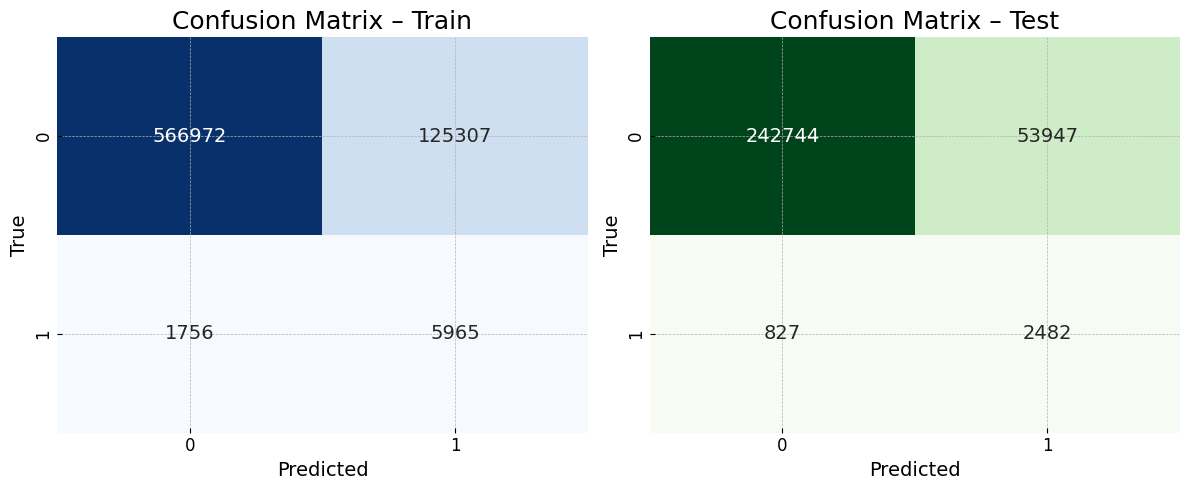


--- TRAIN SCORES ---
ROC-AUC: 0.878365054152535
              precision    recall  f1-score   support

           0       1.00      0.82      0.90    692279
           1       0.05      0.77      0.09      7721

    accuracy                           0.82    700000
   macro avg       0.52      0.80      0.49    700000
weighted avg       0.99      0.82      0.89    700000


--- TEST SCORES ---
ROC-AUC: 0.8609648180893908
              precision    recall  f1-score   support

           0       1.00      0.82      0.90    296691
           1       0.04      0.75      0.08      3309

    accuracy                           0.82    300000
   macro avg       0.52      0.78      0.49    300000
weighted avg       0.99      0.82      0.89    300000



In [63]:
# Confusion Matrices
cm_train = confusion_matrix(y_neuro_train, y_train_predict)
cm_test = confusion_matrix(y_neuro_test, y_test_predict)

# Plot: Train und Test nebeneinander
plt.figure(figsize=(12,5))

# Train
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap="Blues",
            annot_kws={"size": 14}, cbar=False)
plt.title("Confusion Matrix – Train", fontsize=18)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Test
plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap="Greens",
            annot_kws={"size": 14}, cbar=False)
plt.title("Confusion Matrix – Test", fontsize=18)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

# Scores
print("\n--- TRAIN SCORES ---")
print("ROC-AUC:", roc_auc_score(y_neuro_train, probs_train))
print(classification_report(y_neuro_train, y_train_predict))

print("\n--- TEST SCORES ---")
print("ROC-AUC:", roc_auc_score(y_neuro_test, probs_test))
print(classification_report(y_neuro_test, y_test_predict))